In [185]:
import torch
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import resample
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm
from kneed import KneeLocator

import random
import sys
import warnings
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import Counter
import os
import seaborn as sb

from metrics import *
from Misc import *
from Classifier import NeuralNetwork, LogisticRegression, SVM, RandomForest, DecisionTree
from utils import *
from DatasetExt import *
from influence import *
from Algorithms import *

np.random.seed(42)
torch.manual_seed(1)

## Define Dataset's name

In [186]:
dataset_name='income'

In [187]:
'''state_data_counts = {}
all_states = [state.abbr for state in us.states.STATES]
for state in all_states:
    df= load_acs_data(dataset_name, year='2018', states=[state], horizon='1-Year')
    state_data_counts[state] = df.shape[0]
top_five_states = sorted(state_data_counts, key=state_data_counts.get, reverse=True)[:4]
clustered_data = []
states_name=[]

for state in top_five_states:
    df = load_acs_data(dataset_name, states=[state])
    clustered_data.append((df))'''

"state_data_counts = {}\nall_states = [state.abbr for state in us.states.STATES]\nfor state in all_states:\n    df= load_acs_data(dataset_name, year='2018', states=[state], horizon='1-Year')\n    state_data_counts[state] = df.shape[0]\ntop_five_states = sorted(state_data_counts, key=state_data_counts.get, reverse=True)[:4]\nclustered_data = []\nstates_name=[]\n\nfor state in top_five_states:\n    df = load_acs_data(dataset_name, states=[state])\n    clustered_data.append((df))"

In [188]:
'''for state_name, df in zip(top_five_states, clustered_data):
    print(f"Shape of data for {state_name}: {df.shape}")'''

'for state_name, df in zip(top_five_states, clustered_data):\n    print(f"Shape of data for {state_name}: {df.shape}")'

## Load Dataset

In [189]:
datapool, test_orig_df=load_data(dataset_name)
Target_attribute, Sensitive_attribute, protected_group, privileged_group= get_target_sensitive_attribute(dataset_name)
dataset_orig_df = pd.concat([datapool, test_orig_df], ignore_index=True)

## Synthetic Dataset

In [190]:
#datapool = generate_synthetic_data(datapool_orig, 100000)

## Define Training and Budget Percentages

In [191]:
train_pct=5
train_size=int(dataset_orig_df.shape[0]*(train_pct/100))

In [192]:
train_smart_df= smart_sample(datapool, train_size , 50, 70, dataset_name)  #keep it balance for the sake of accuracy
datapool = datapool.drop(train_smart_df.index)

In [193]:
print("Original dataset: ", dataset_orig_df.shape)
print("Train set: ", train_smart_df.shape)
print("Test set: ", test_orig_df.shape)
print("Size of Data Pool: ", datapool.shape)

Original dataset:  (195665, 11)
Train set:  (9783, 11)
Test set:  (39133, 11)
Size of Data Pool:  (146749, 11)


In [194]:
budget_pct=20
mini_batch_pct=10
data_acq_size=int(datapool.shape[0]*budget_pct//100)
mini_batch_size=int(data_acq_size*(mini_batch_pct/100))
print('mini batch size:', mini_batch_size)
print('Budget Size:', data_acq_size)

mini batch size: 2934
Budget Size: 29349


## Initial Model Training

In [195]:
X_train = train_smart_df.drop(columns=[Target_attribute])
y_train = train_smart_df[Target_attribute]
X_test = test_orig_df.drop(columns=[Target_attribute])
y_test = test_orig_df[Target_attribute]

In [196]:
model_smart=LogisticRegression(input_size=X_train.shape[-1])

In [197]:
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig=prepare_train_data(train_smart_df, test_orig_df, Target_attribute)

In [198]:
num_params = len(convert_grad_to_ndarray(list(model_smart.parameters())))
if isinstance(model_smart, LogisticRegression):
    loss_func = logistic_loss_torch
elif isinstance(model_smart, SVM):
    loss_func = svm_loss_torch
elif isinstance(model_smart, NeuralNetwork):
    loss_func = nn_loss_torch

In [199]:
model_smart.fit(X_train, y_train)
y_pred_test = model_smart.predict_proba(X_test)
y_pred_train = model_smart.predict_proba(X_train)

In [200]:
spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset_name)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset_name)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)


Initial statistical parity:  -0.21509353569193762
Initial TPR parity:  -0.20291867450426027
Initial predictive parity:  -0.08585307896842087
Initial loss:  0.49806339886912543
Initial accuracy:  0.7654664860859122


In [201]:
ini_parity=spd_0
X_train_full, X_test_full, y_train_full, y_test_full, X_train_orig_full, X_test_orig_full=prepare_train_data(dataset_orig_df, test_orig_df, Target_attribute)
model_full=copy.deepcopy(model_smart)
model_full.fit(X_train_full, y_train_full)   
y_pred_test_full=model_full.predict_proba(X_test)
full_parity = computeFairness(y_pred_test_full, X_test_orig, y_test, 0, dataset_name)
ini_acc=computeAccuracy(y_test_full, y_pred_test_full)
print('Initial Parity', ini_parity)
print('Fairness for Entire Data Pool', full_parity)

Initial Parity -0.21509353569193762
Fairness for Entire Data Pool -0.08852007774118792


In [202]:
privileged_positive, privileged_negative, protected_positive, protected_negative, privieleged_data_full, protected_data_full = get_group_count(dataset_orig_df, dataset_name)

## Distribution Check

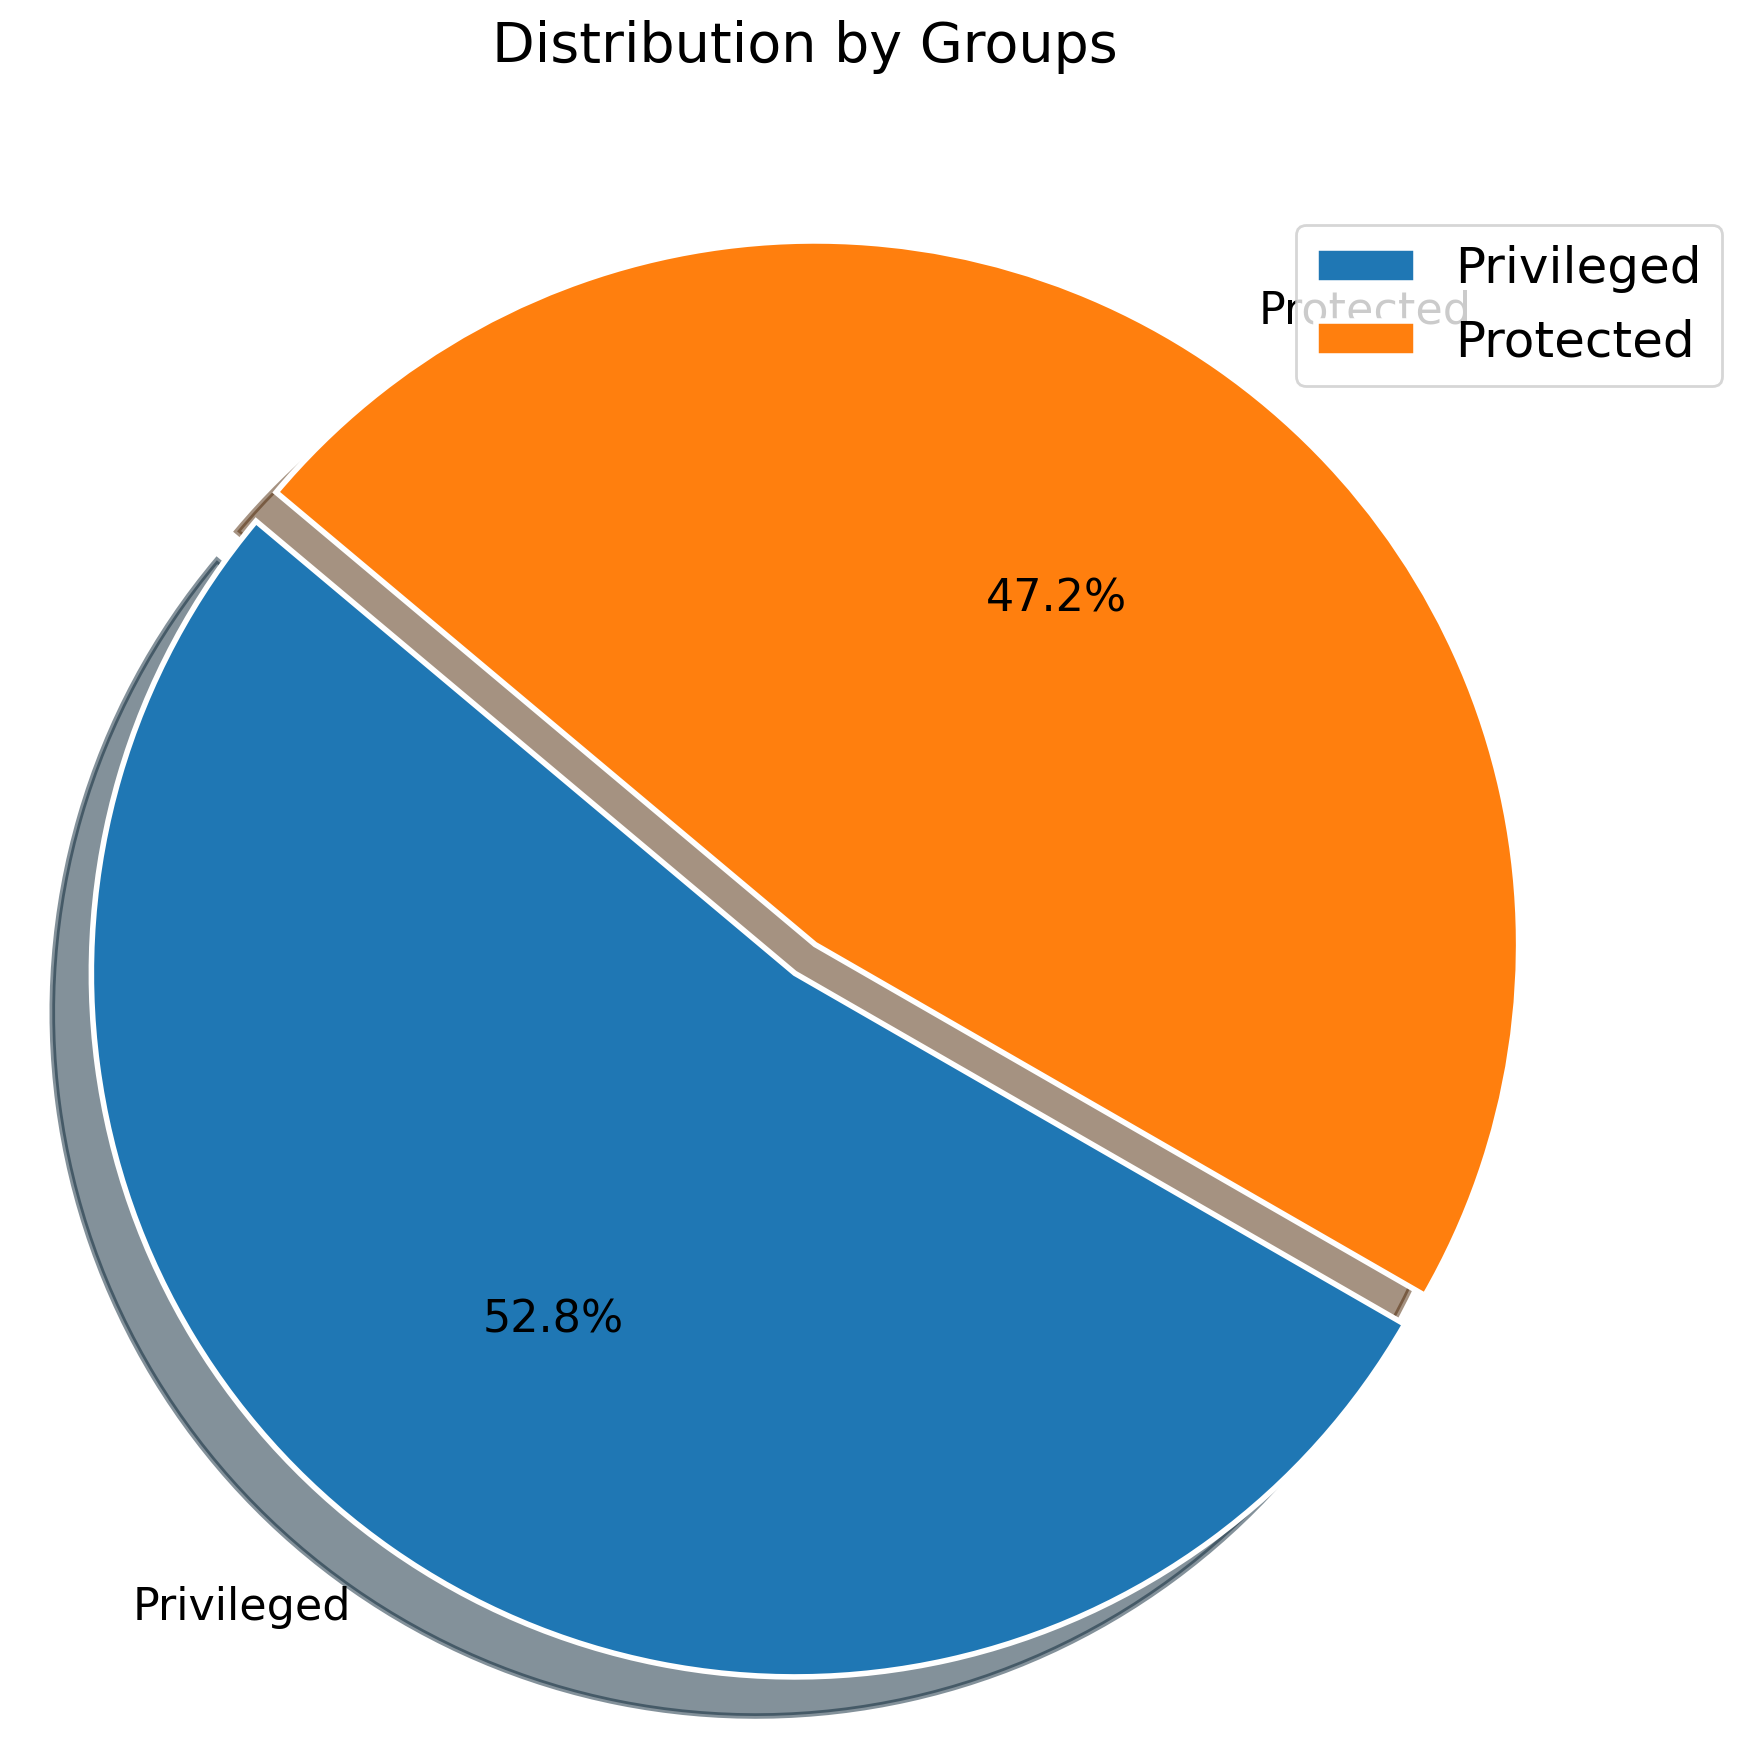

In [203]:
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 18, 'font.family': 'DejaVu Sans', 'figure.dpi': 200})

labels = ['Privileged', 'Protected']
values = [privieleged_data_full.shape[0], protected_data_full.shape[0]]

colors = ['#1f77b4', '#ff7f0e']
explode = (0.05, 0)

plt.figure(figsize=(10, 10))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, 
        explode=explode, colors=colors, shadow=True, 
        textprops={'fontsize': 16}, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})

plt.title('Distribution by Groups', fontsize=20, y=1.08)
plt.legend(labels, loc="upper right", bbox_to_anchor=(1.1, 1))
plt.axis('equal')
plt.tight_layout(pad=3)
plt.show()

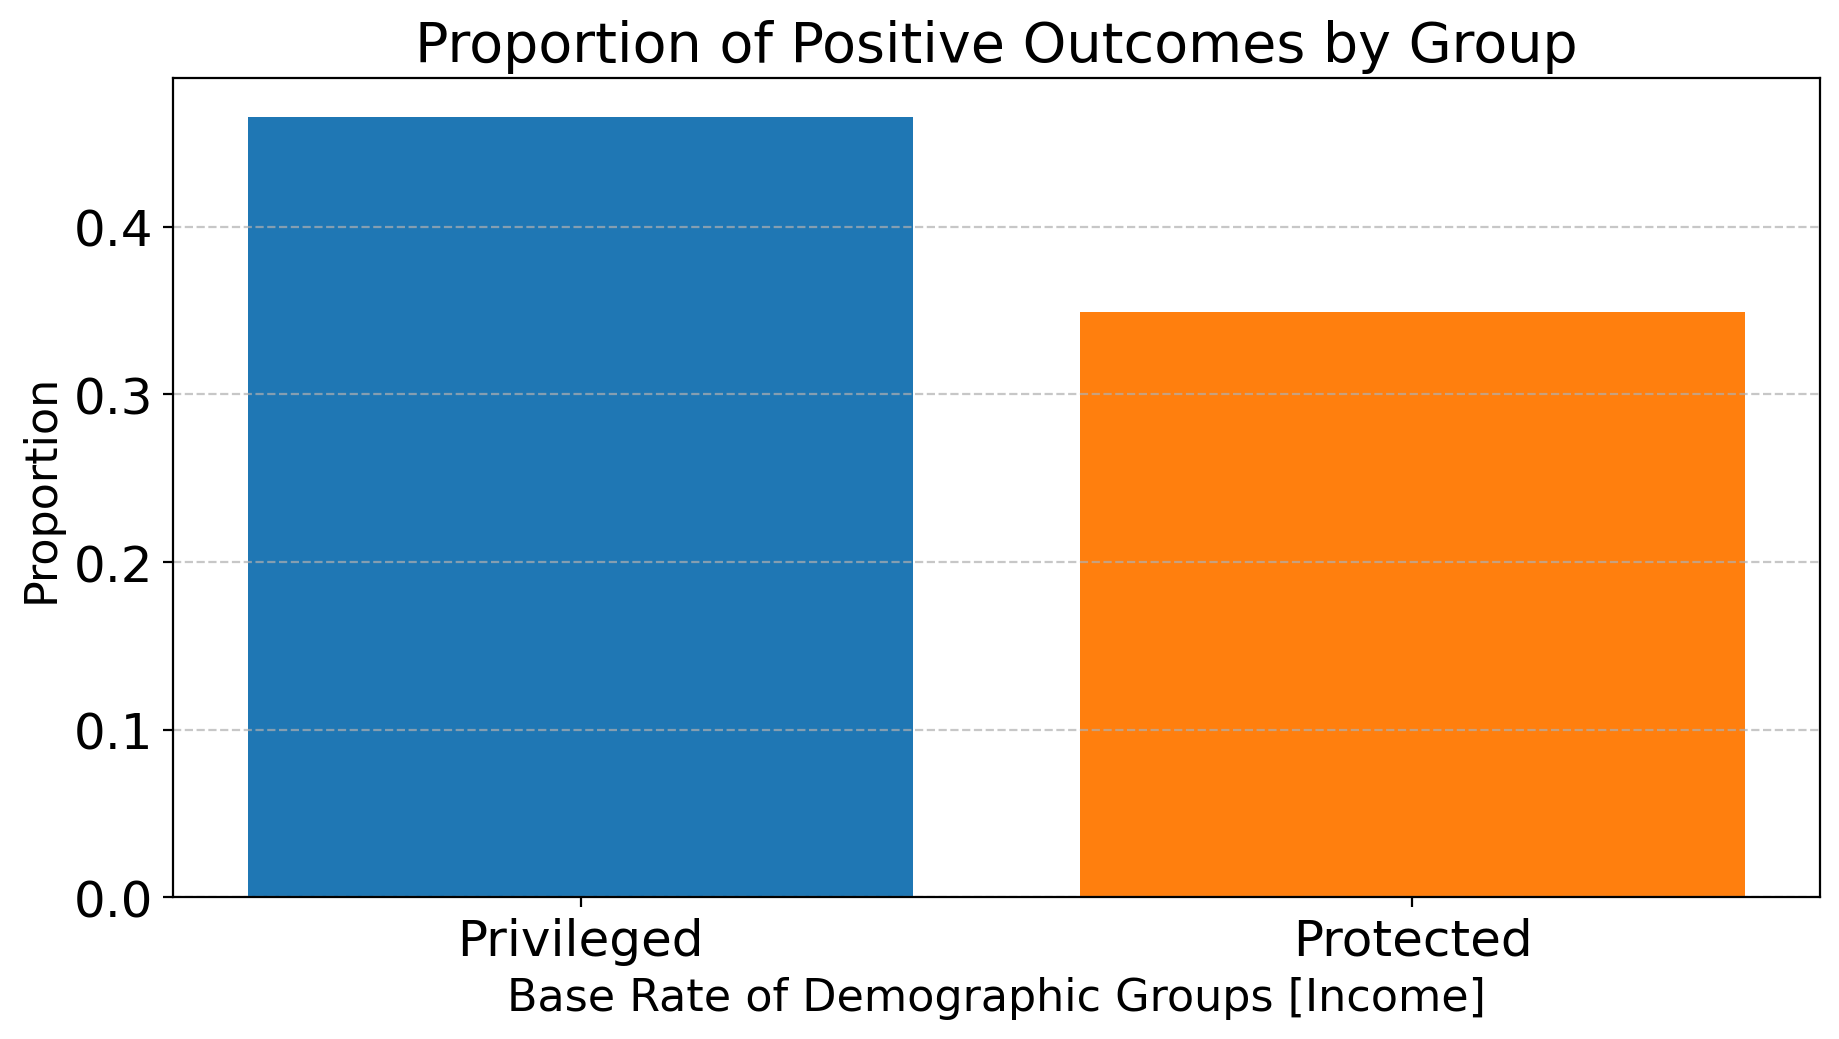

In [204]:
plt.rcParams.update({'font.size': 18, 'font.family': 'DejaVu Sans', 'figure.dpi': 200})

labels = ['Privileged', 'Protected']
values = [privileged_positive.shape[0]/privieleged_data_full.shape[0], 
          protected_positive.shape[0]/protected_data_full.shape[0]]


plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#1f77b4', '#ff7f0e'])

plt.xlabel('Base Rate of Demographic Groups [Income]', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.title('Proportion of Positive Outcomes by Group', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2)
plt.show()

## First Order Influence

In [205]:
metric = 0  # spd -> 0, tpr parity -> 1, predictive parity -> 2
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]

v1 = get_del_F_del_theta(model_smart, X_test_orig, X_test, y_test, dataset_name, metric)
v1=v1.reshape(-1,1)

hessian_all_points = get_hessian_all_points(model_smart, X_train, y_train, loss_func)
del_L_del_theta = get_del_L_del_theta(model_smart, X_train, y_train, loss_func)
hinv_v, hinv = get_hinv_v(hessian_all_points, v1)
Inf_par=(1/X_train.shape[0])*(-del_L_del_theta@hinv)
Influence_loss= -np.dot(hinv, del_L_del_theta.T)
Influence_fair=Inf_par@v1

100%|██████████| 9783/9783 [00:25<00:00, 381.35it/s]


## Clustering

In [206]:
optimal_cluster_no=find_optimal_gmm_components(datapool)
clustered_data=gmm_clustering(datapool,4)

Cluster 1 shape: (88194, 11)
Cluster 2 shape: (337, 11)
Cluster 3 shape: (51809, 11)
Cluster 4 shape: (6409, 11)


## Influence Estimation for Data Pool

## K-NN

In [207]:
'''sort_by_inf_partition = []
sort_by_inf = []
for data in clustered_data:
    sorted_cluster_data, sorted_influences_fair = sorted_influence_KNN(train_smart_df, data, Influence_fair, k=100)
    sort_by_inf_partition.append(sorted_cluster_data)
    sort_by_inf.append(sorted_influences_fair)'''

'sort_by_inf_partition = []\nsort_by_inf = []\nfor data in clustered_data:\n    sorted_cluster_data, sorted_influences_fair = sorted_influence_KNN(train_smart_df, data, Influence_fair, k=100)\n    sort_by_inf_partition.append(sorted_cluster_data)\n    sort_by_inf.append(sorted_influences_fair)'

## Regression

In [208]:
model_ridge, X_test_poly, y_test_inf= train_reg_model(train_smart_df, Influence_fair, 'Influence')

Ridge R-squared (R²): 0.9935193556203424


In [209]:
y_pred_inf = model_ridge.predict(X_test_poly)

## Get Sorted Data Pool

In [210]:
sorted_datapool, datapool_sorted_influences = sorted_influences_reg(datapool, model_ridge)

## Ger Sorted Cluster

In [211]:
sort_by_inf_partition = []
sort_by_inf = []
for data in clustered_data:
    sorted_cluster_data, sorted_influences = sorted_influences_reg(data, model_ridge)
    sort_by_inf_partition.append(sorted_cluster_data)
    sort_by_inf.append(sorted_influences)

## Algorithms

## MAB Acquisition

In [212]:
tau=0.01

In [213]:
Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=tau, budget=data_acq_size, alpha=0.1)

## MAB_INF Acquisition

In [214]:
MAB_inf_update_data, MAB_inf_iteration_count, MAB_inf_iteration_count_ex, MAB_inf_parity_ex, stat_MAB_inf, MAB_inf_accuracy_ex, MAB_inf_time_per_iteration, MAB_inf_cluster_count, iteration_time_MAB_inf = mab_inf_algorithm(sort_by_inf_partition, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=tau, budget=data_acq_size, alpha=0.1)

## MAB_dist

In [215]:
normalized_distance=compute_normalized_distances(clustered_data)

In [216]:
Stat_update_data_dist, i_values_stat_dist, i_values_ex_stat_dist, stat_ex_dist, stat_dist, acc_stat_dist, time_per_iteration_stat_dist, cluster_count_dist, iteration_time1_dist = mab_algorithm_dist(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=tau, budget=data_acq_size, Euclid_normalized_d=normalized_distance, alpha=0.1)

## Random Acquisition

In [217]:
data_random, i_values_ex_ran, i_values_ran, stat_ran, stat_ex_ran, acc_ran, time_per_iteration_ran =random_algorithm(datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

## Entropy

In [218]:
data_entropy, i_values_ex_ent, i_values_ent, stat_ent, stat_ex_ent, acc_ent, time_per_iteration_ent =entropy_based_algorithm(datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

## Only Influence

In [219]:
data_inf, i_values_ex_inf, i_values_inf, stat_inf, stat_ex_inf, acc_inf, time_per_iteration_inf =inf_algorithm(sorted_datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=tau, budget=data_acq_size)

## Multi-Armed Bandit Vs Others

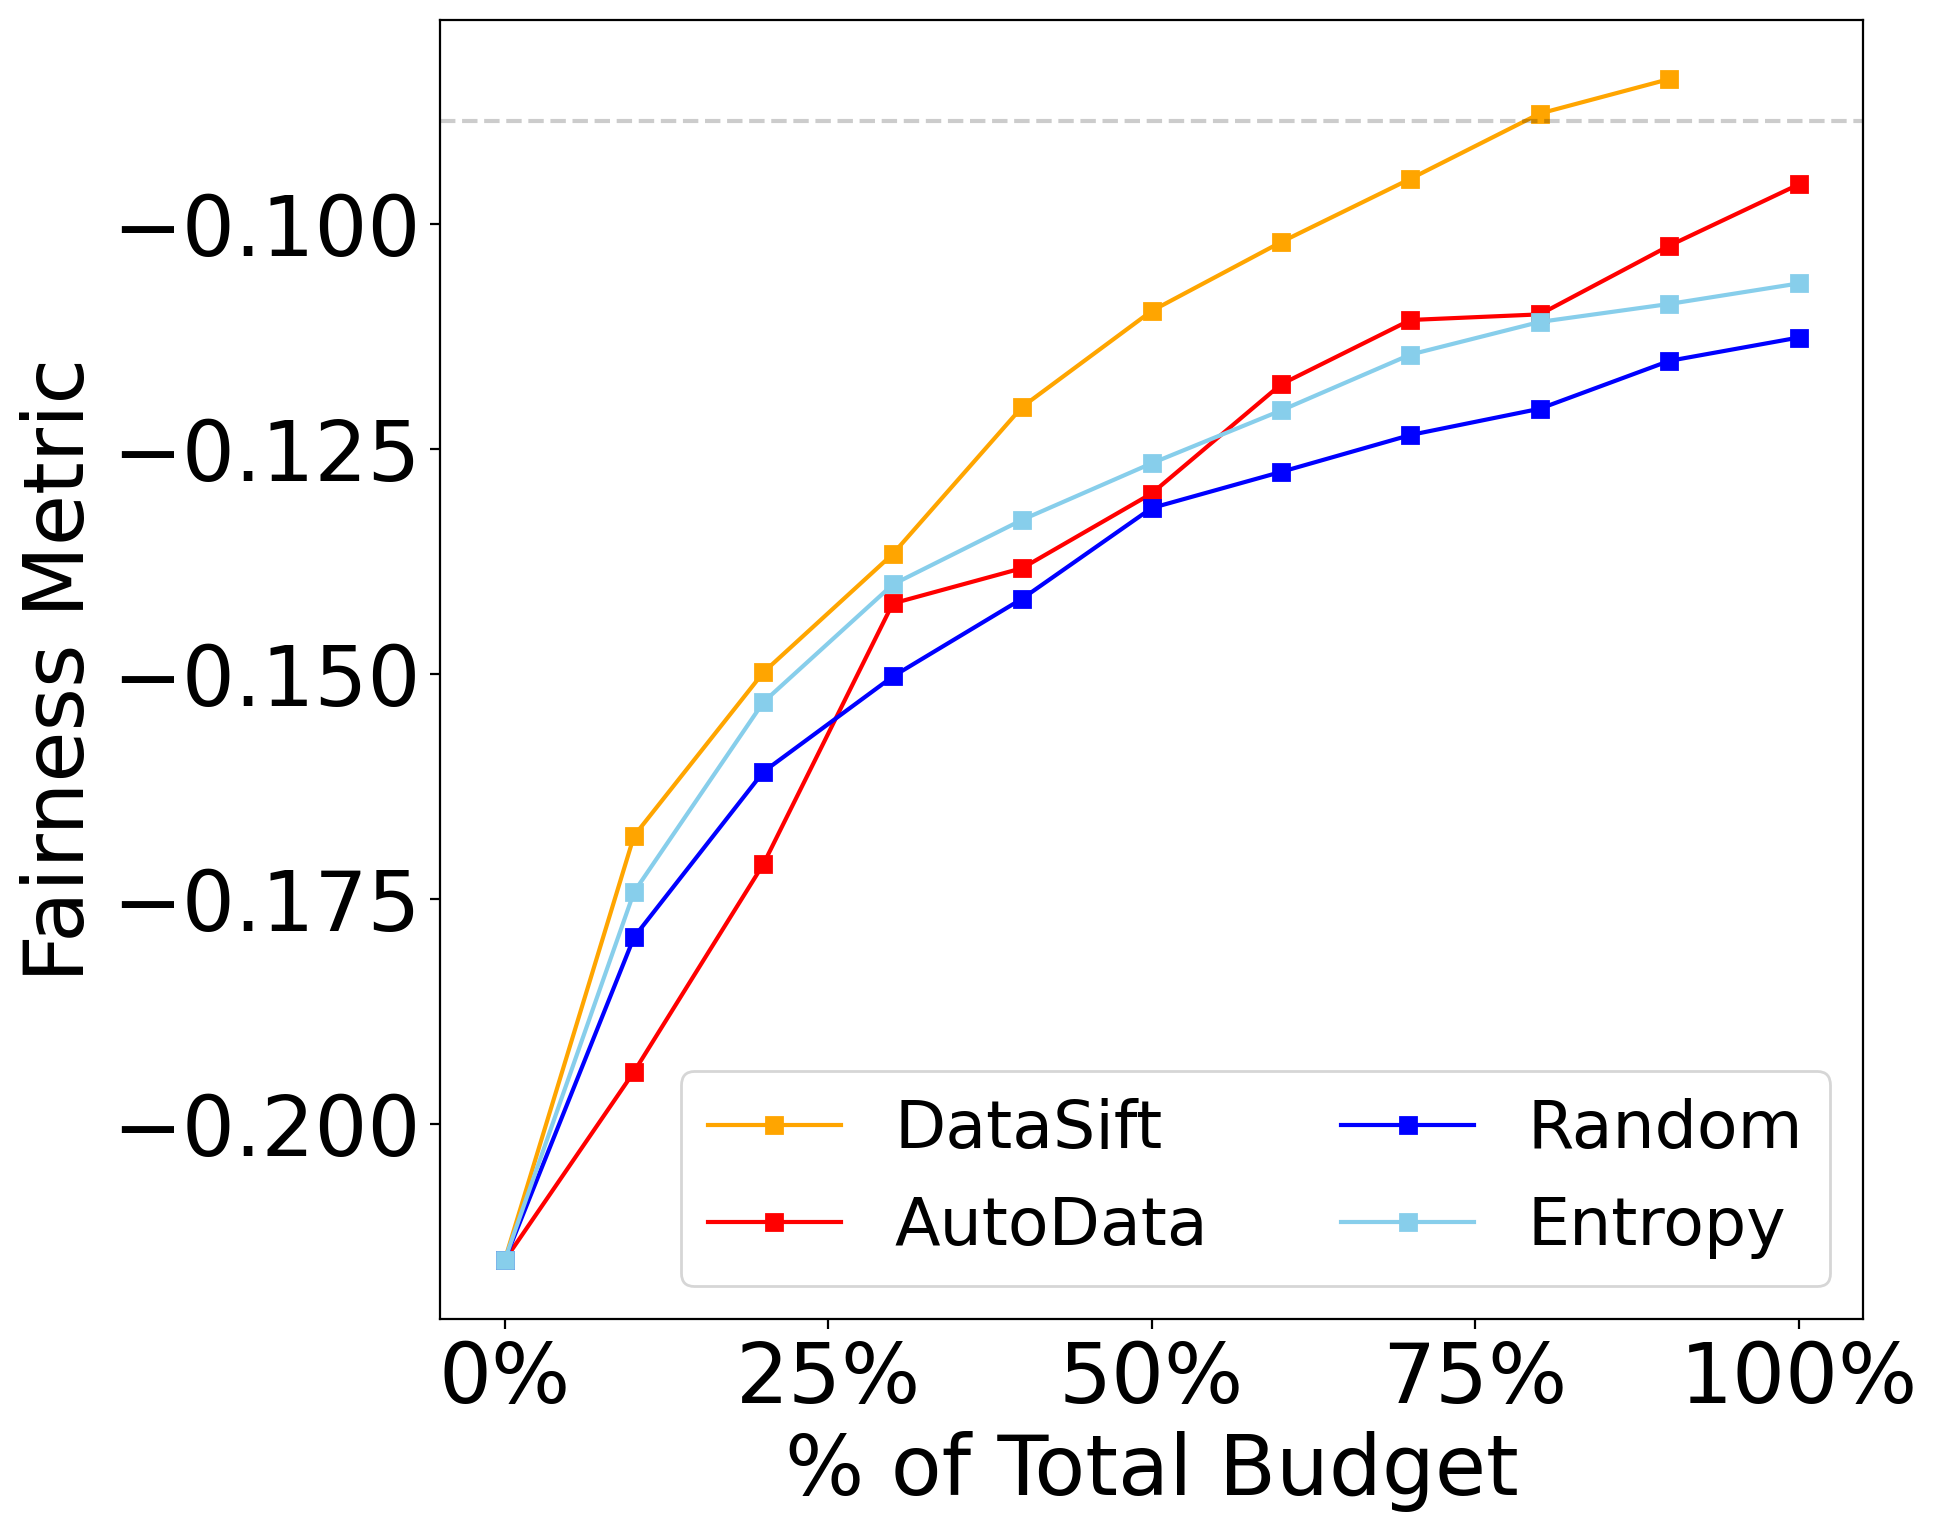

In [220]:
plt.figure(figsize=(10,8))

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift',
)
plt.plot(
    [i for i in i_values_ex_stat_dist if i % 1 == 0], 
    [stat_ex_dist[i_values_ex_stat_dist.index(i)] for i in i_values_ex_stat_dist if i % 1 == 0], 
    color='r', marker='s', linestyle='-', label='AutoData'
)
plt.plot(
    [i for i in i_values_ex_ran if i % 1 == 0], 
    [stat_ex_ran[i_values_ex_ran.index(i)] for i in i_values_ex_ran if i % 1 == 0], 
    color='b', marker='s', linestyle='-', label='Random'
)

plt.plot(
    [i for i in i_values_ex_ent if i % 1 == 0], 
    [stat_ex_ent[i_values_ex_ent.index(i)] for i in i_values_ex_ent if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Entropy'
)

plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=24, ncol=2)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()


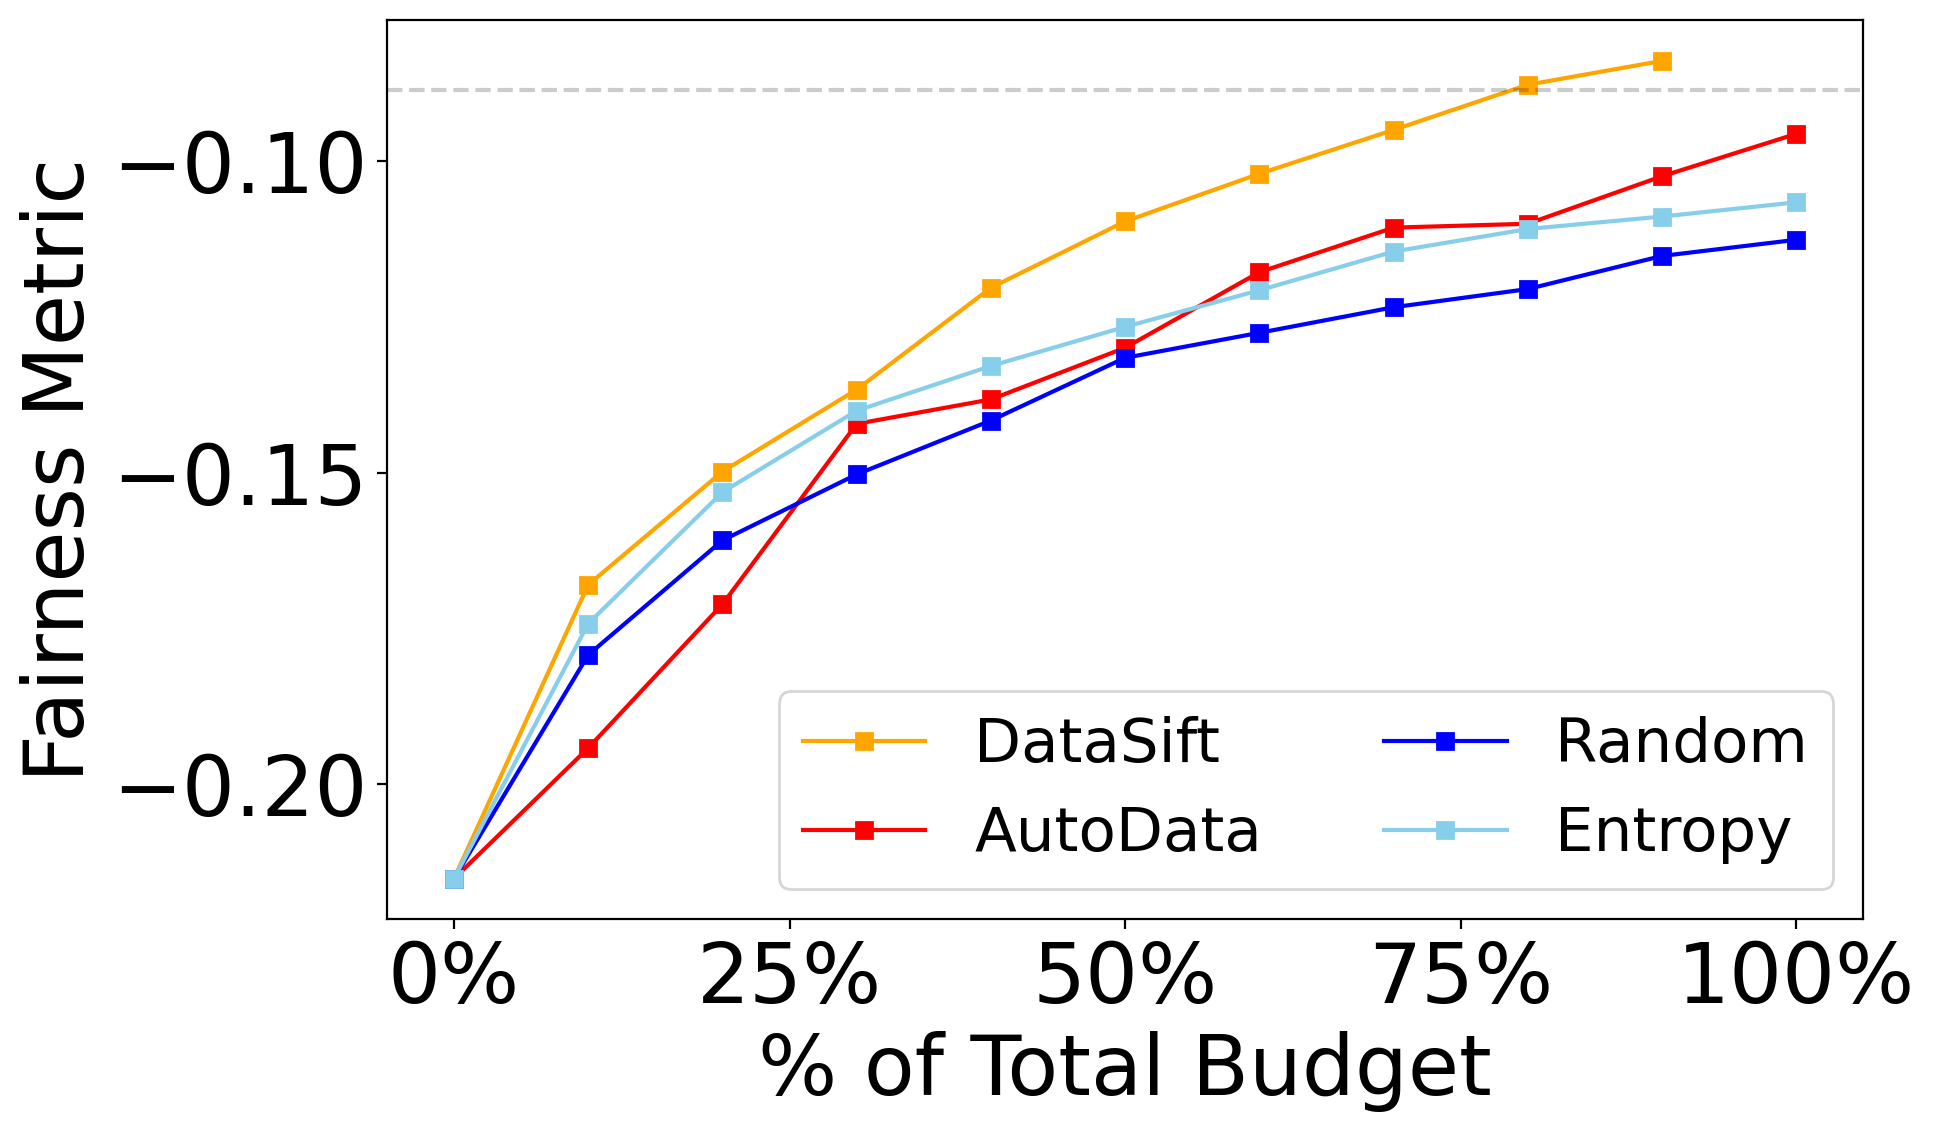

In [235]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/DataSift Final'
file_name = 'Income_rec_.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(10,6))

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift',
)
plt.plot(
    [i for i in i_values_ex_stat_dist if i % 1 == 0], 
    [stat_ex_dist[i_values_ex_stat_dist.index(i)] for i in i_values_ex_stat_dist if i % 1 == 0], 
    color='r', marker='s', linestyle='-', label='AutoData'
)
plt.plot(
    [i for i in i_values_ex_ran if i % 1 == 0], 
    [stat_ex_ran[i_values_ex_ran.index(i)] for i in i_values_ex_ran if i % 1 == 0], 
    color='b', marker='s', linestyle='-', label='Random'
)

plt.plot(
    [i for i in i_values_ex_ent if i % 1 == 0], 
    [stat_ex_ent[i_values_ex_ent.index(i)] for i in i_values_ex_ent if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Entropy'
)


plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=2)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

## Data Valuation

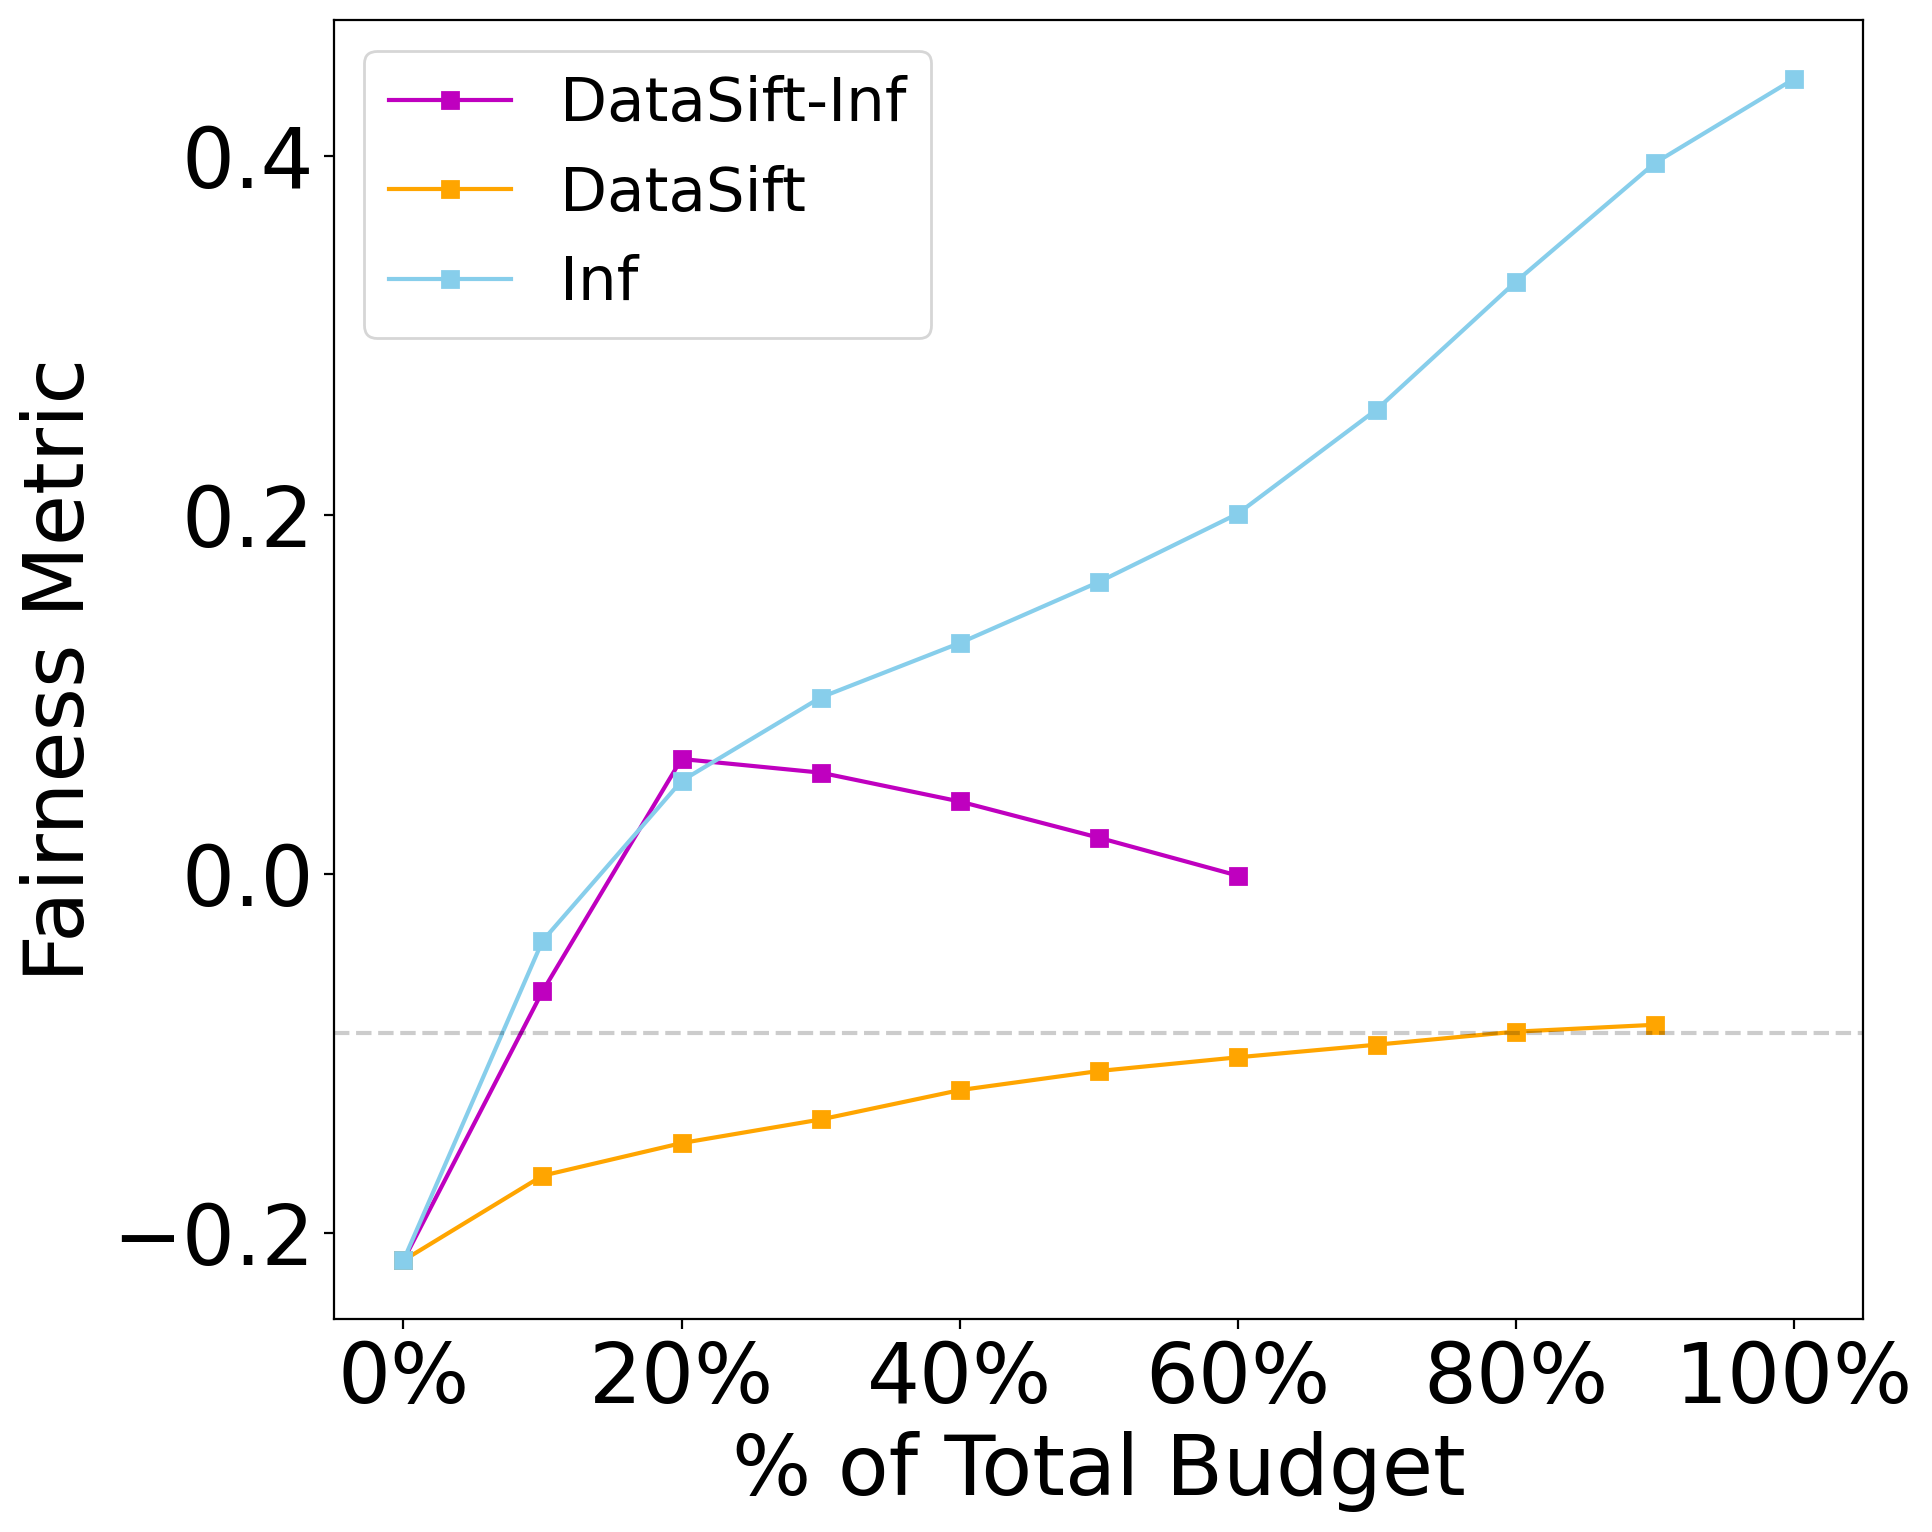

In [222]:
plt.figure(figsize=(10, 8))
plt.plot(
    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    color='m', marker='s', linestyle='-', label='DataSift-Inf'
)
plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift'
)
plt.plot(
    [i for i in i_values_ex_inf if i % 1 == 0], 
    [stat_ex_inf[i_values_ex_inf.index(i)] for i in i_values_ex_inf if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Inf'
)


plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()


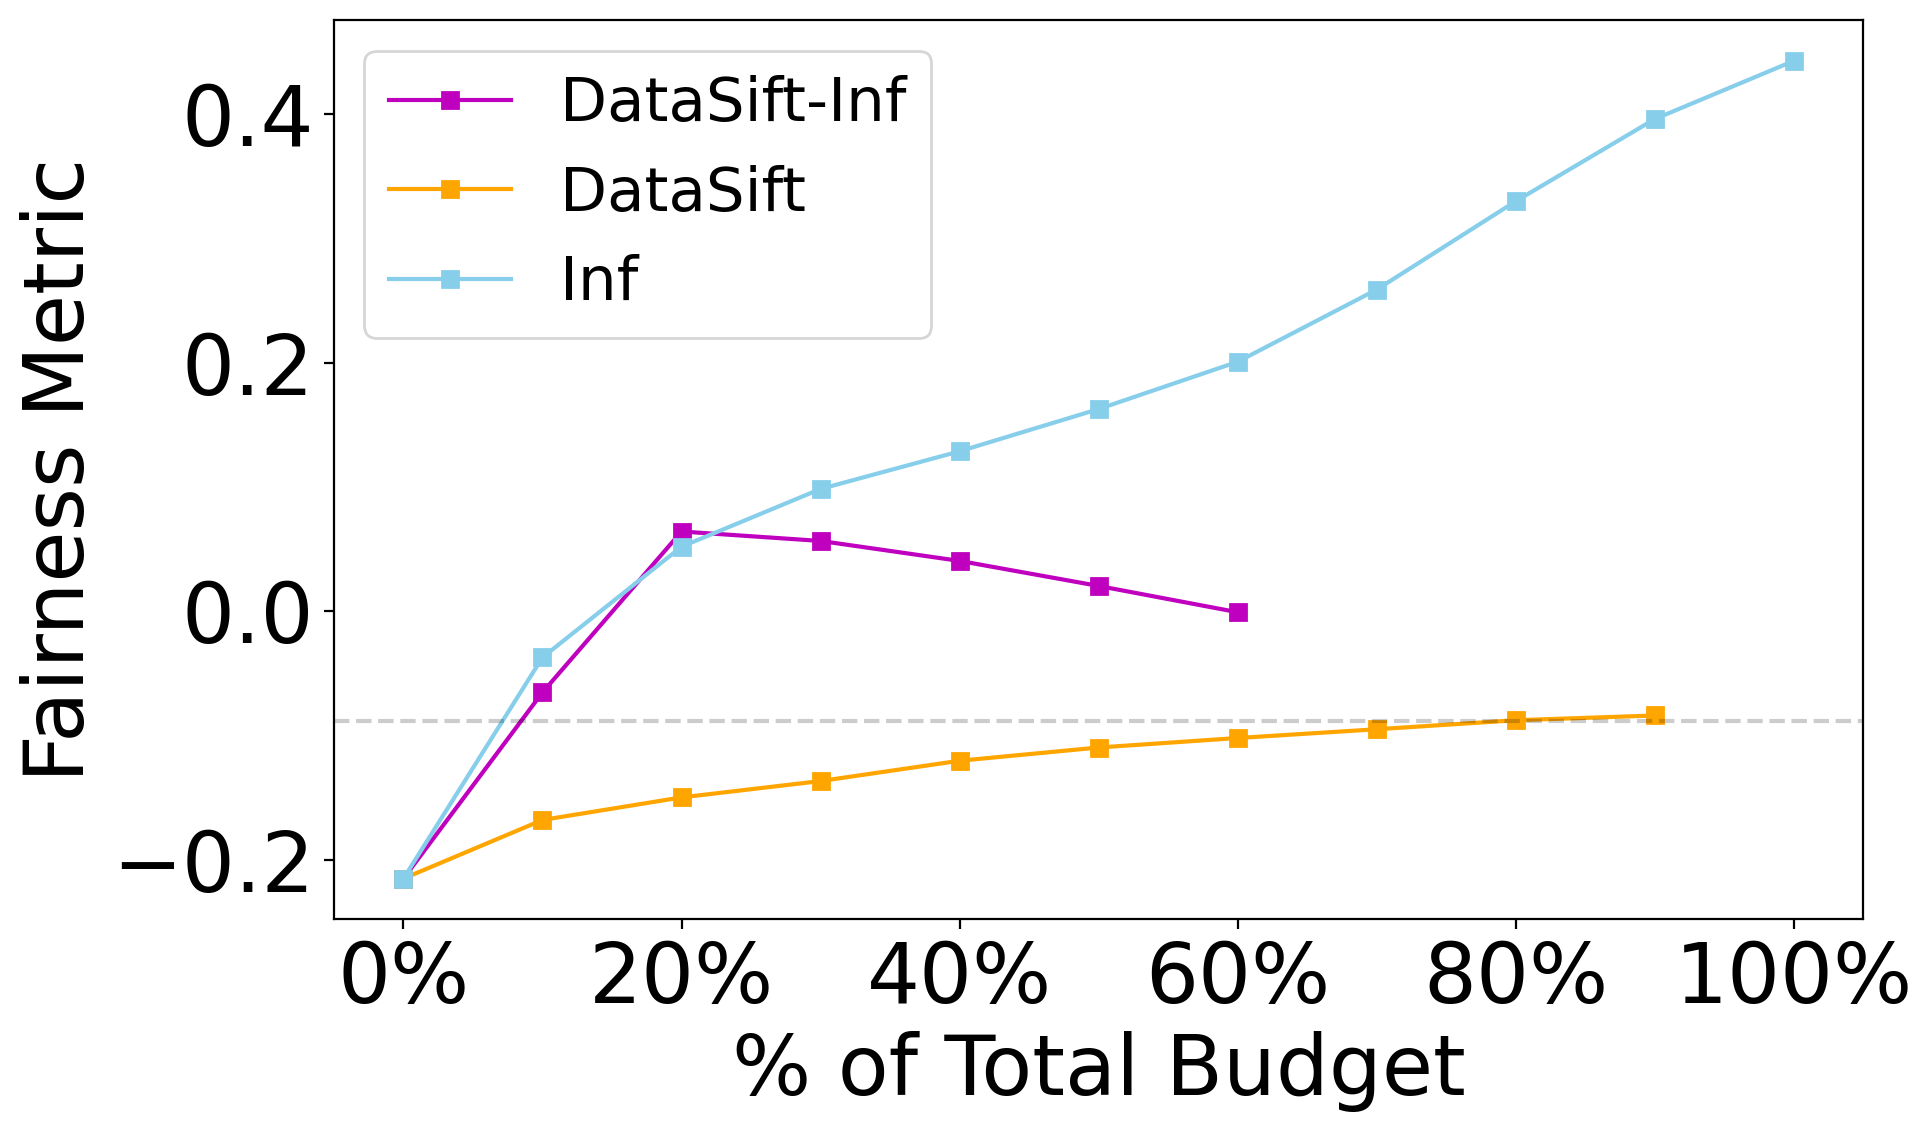

In [223]:
plt.figure(figsize=(10, 6))
plt.plot(
    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    color='m', marker='s', linestyle='-', label='DataSift-Inf'
)
plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift'
)
plt.plot(
    [i for i in i_values_ex_inf if i % 1 == 0], 
    [stat_ex_inf[i_values_ex_inf.index(i)] for i in i_values_ex_inf if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Inf'
)


plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()

## Observation In each Iteration

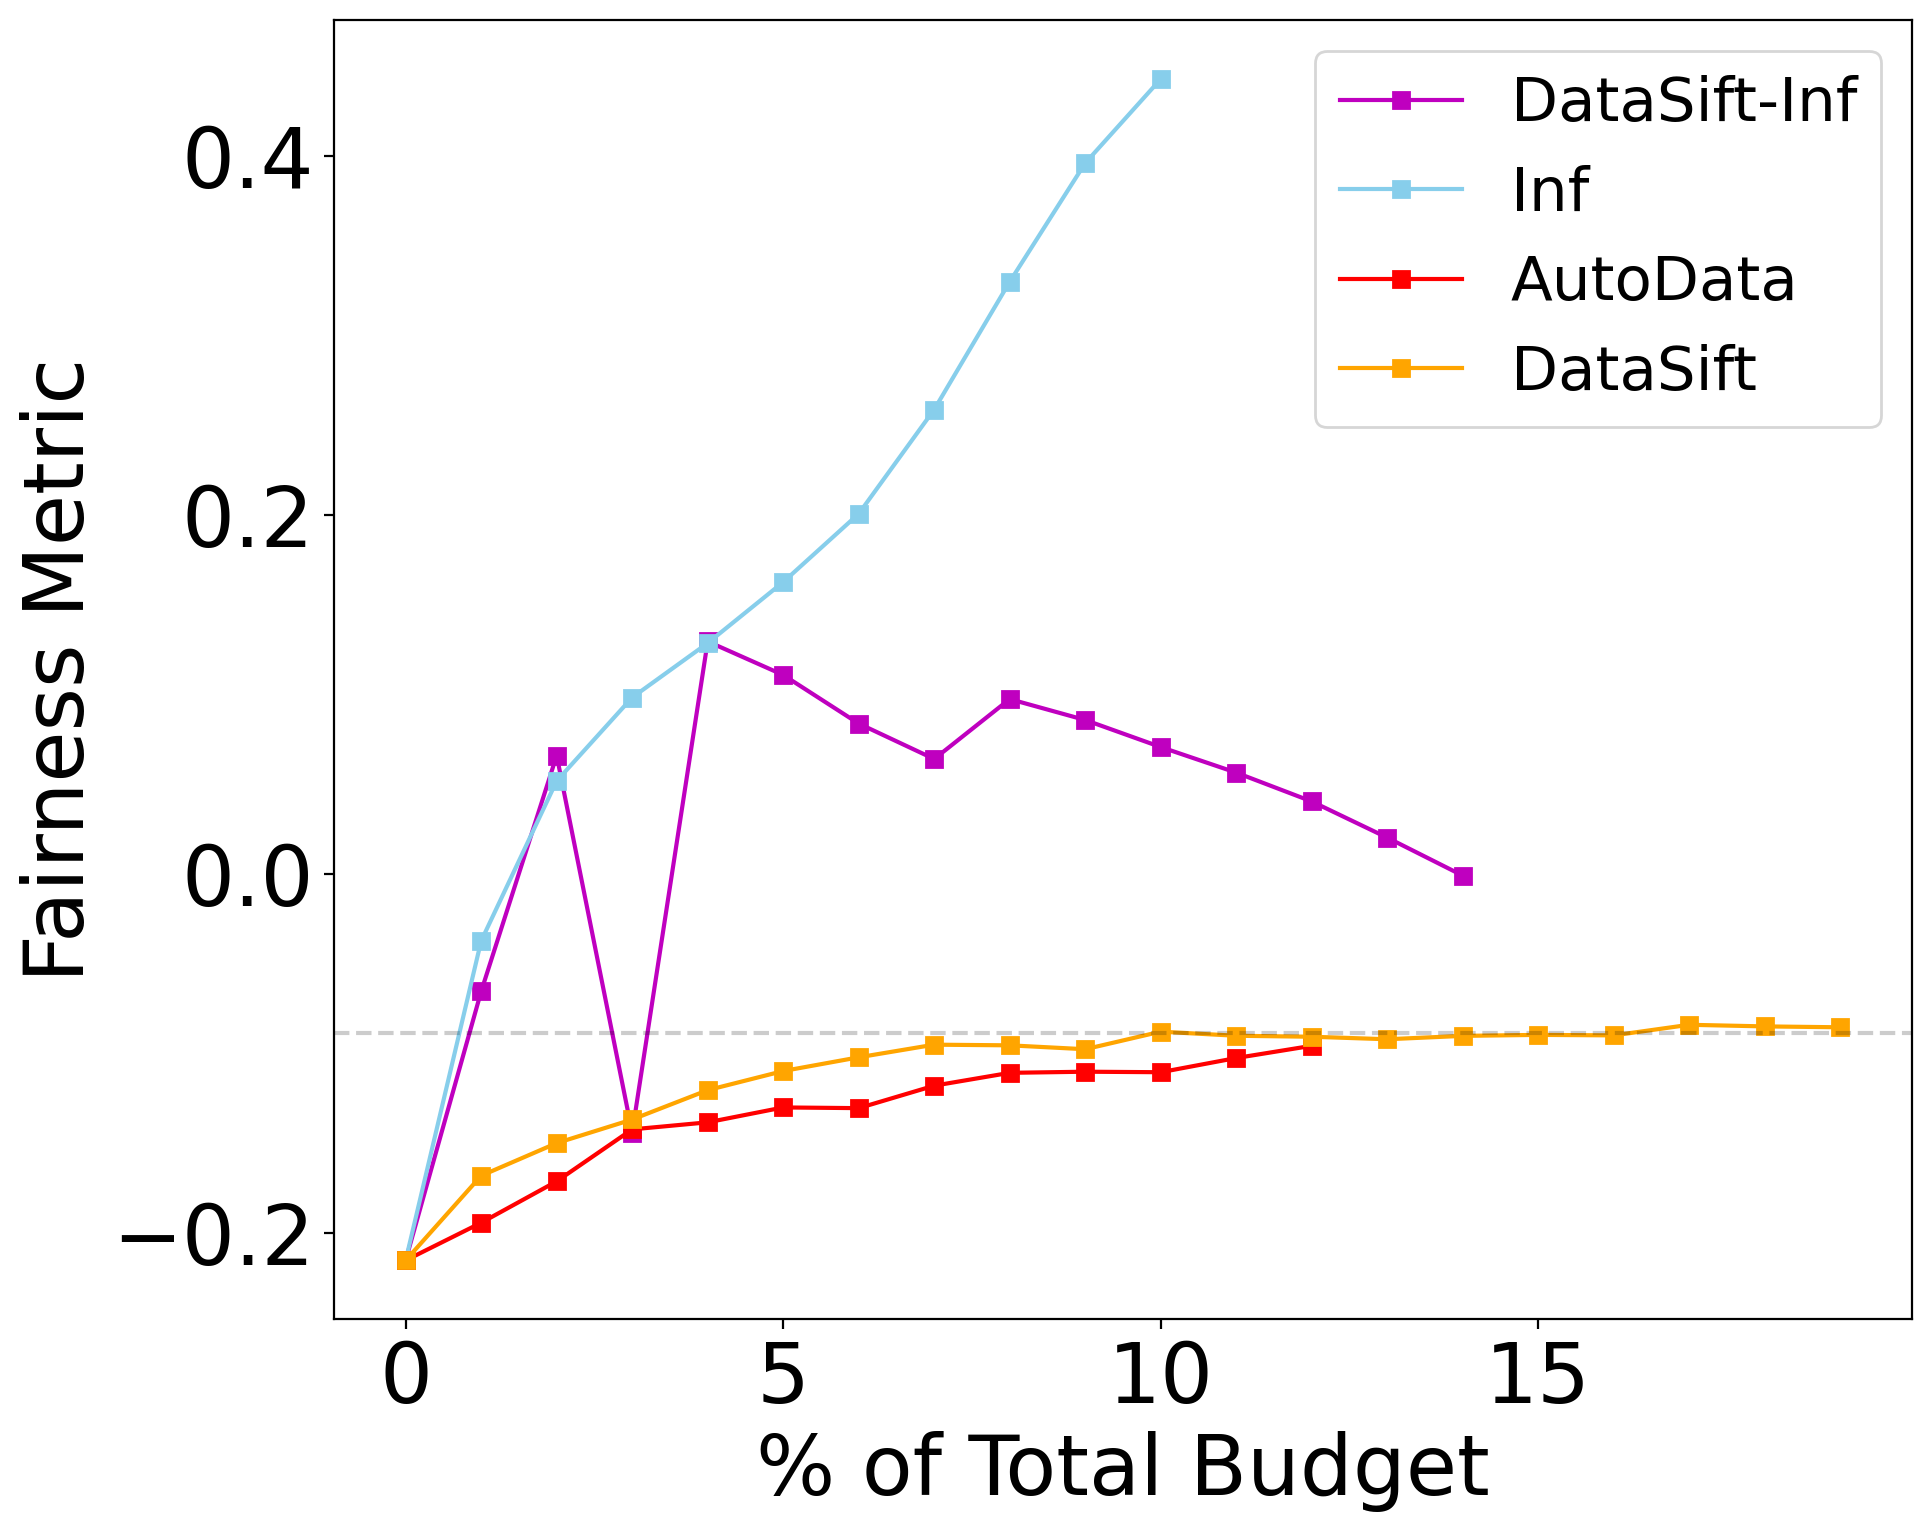

In [224]:
plt.figure(figsize=(10,8))


plt.plot(
    [i for i in MAB_inf_iteration_count if i % 1 == 0], 
    [stat_MAB_inf[MAB_inf_iteration_count.index(i)] for i in MAB_inf_iteration_count if i % 1 == 0], 
    color='m', marker='s', linestyle='-', label='DataSift-Inf'
)
plt.plot(
    [i for i in i_values_inf if i % 1 == 0], 
    [stat_inf[i_values_inf.index(i)] for i in i_values_inf if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Inf'
)
plt.plot(
    [i for i in i_values_stat_dist if i % 1 == 0], 
    [stat_dist[i_values_stat_dist.index(i)] for i in i_values_stat_dist if i % 1 == 0], 
    color='r', marker='s', linestyle='-', label='AutoData'
)

plt.plot(
    [i for i in i_values_stat if i % 1 == 0], 
    [stat[i_values_stat.index(i)] for i in i_values_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='DataSift'
)



plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')


plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()

## Accuracy Observatiuon

<Figure size 1280x960 with 0 Axes>

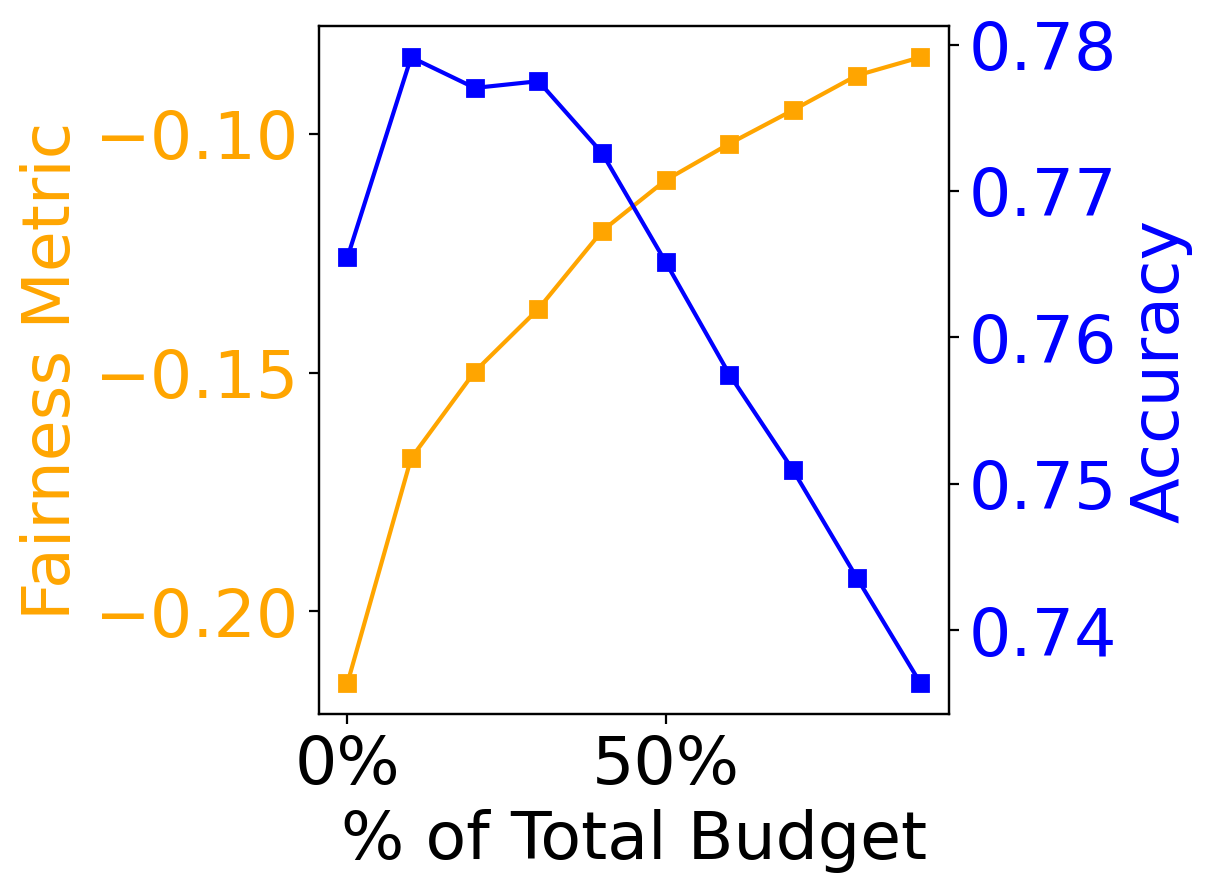

In [225]:
plt.figure(figsize=(6.4, 4.8))  
fig, ax1 = plt.subplots(figsize=(6.4, 4.8))

line1, = ax1.plot(
    i_values_ex_stat, 
    stat_ex,
    color='orange', marker='s', linestyle='-', label='DataSift'
)

ax1.set_xlabel('% of Total Budget', fontsize=24)
ax1.set_ylabel('Fairness Metric', color='orange', fontsize=24)
ax1.tick_params(axis='y', labelcolor='orange', labelsize=24)
ax1.tick_params(axis='x', labelsize=24) 


ax2 = ax1.twinx()  

line2, = ax2.plot(
    i_values_ex_stat, 
    acc_stat, 
    color='blue', marker='s', linestyle='-', label='Accuracy'
)

ax2.set_ylabel('Accuracy', color='blue', fontsize=24)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=24)
plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.tight_layout()
plt.show()


In [226]:
print('Initial Acc', accuracy_0)
print('Random Accuracy', acc_ran[-1])
print('Entropy Accuracy', acc_ent[-1])
print('AutoData Accuracy', acc_stat_dist[-1])
print('MAB Accuracy', acc_stat[-1])
print('Only Influence Accuracy', acc_inf[-1])
print('MAB_INF Accuracy', MAB_inf_accuracy_ex[-1])


Initial Acc 0.7654664860859122
Random Accuracy 0.7839674954641862
Entropy Accuracy 0.778166764623208
AutoData Accuracy 0.7735159583982828
MAB Accuracy 0.7363861702399509
Only Influence Accuracy 0.5555158050750006
MAB_INF Accuracy 0.7512074208468555


## Efficiency

In [227]:
print('Random time', time_per_iteration_ran)
print('Entropy time', time_per_iteration_ent)
print('AutoData time', iteration_time1_dist)
print('MAB time', iteration_time1)
print('Only Influence time', time_per_iteration_inf)
print('MAB_INF time', iteration_time_MAB_inf)

Random time 3.3223726749420166
Entropy time 3.212553024291992
AutoData time 2.349839210510254
MAB time 7.724477767944336
Only Influence time 3.071932792663574
MAB_INF time 4.9699482917785645


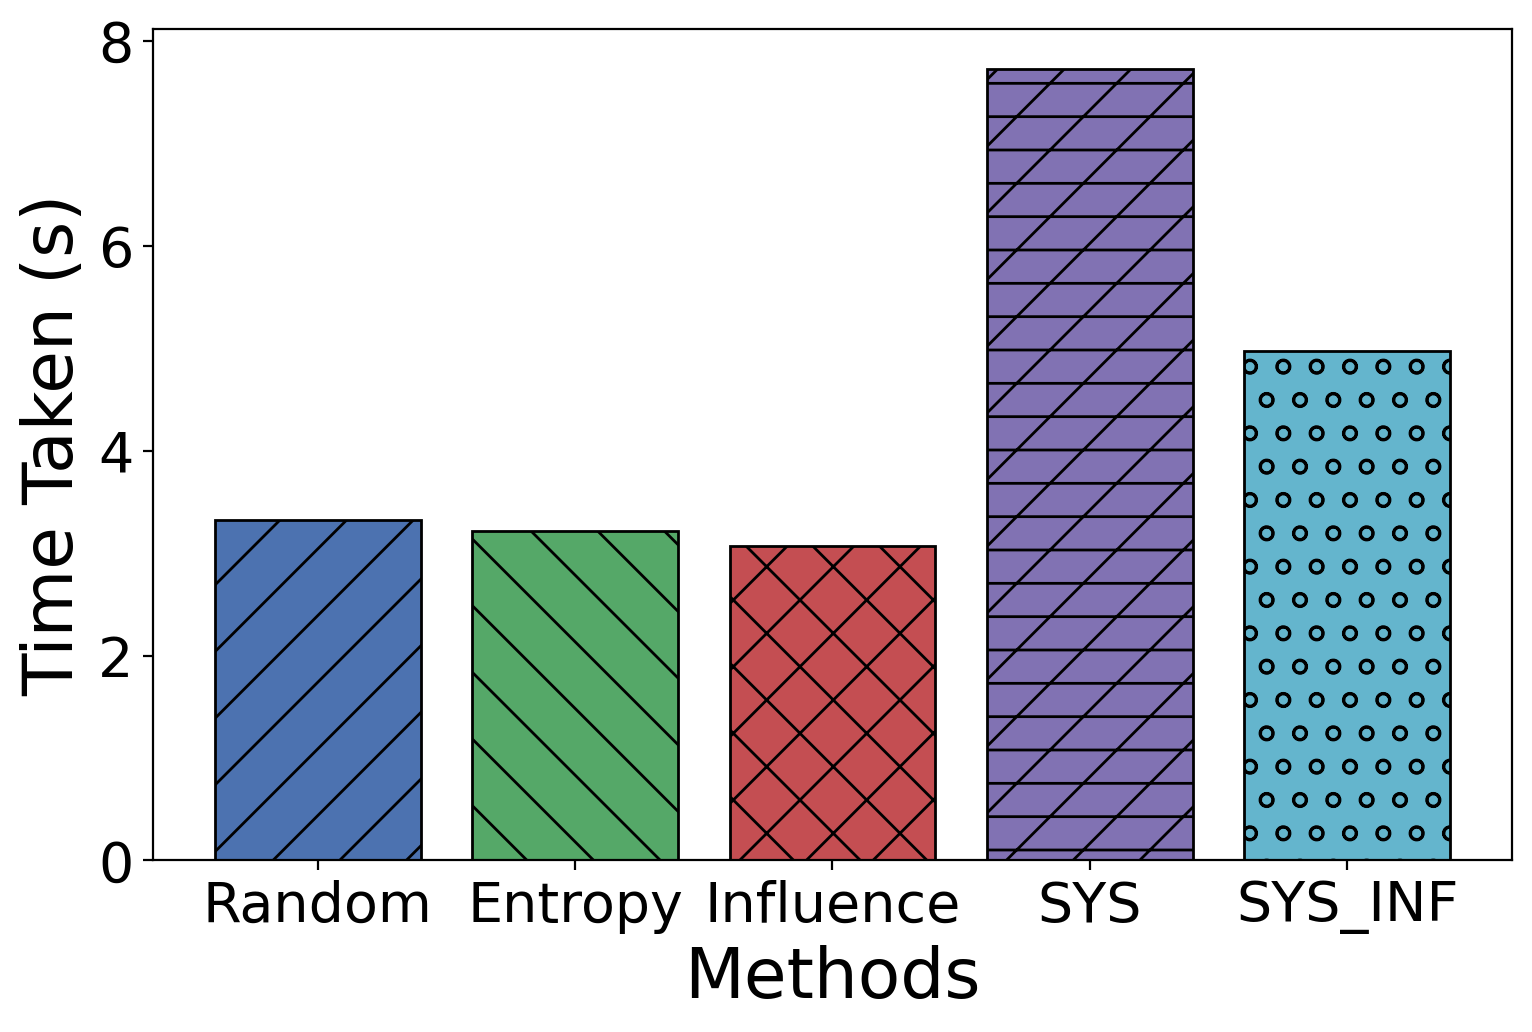

In [228]:
methods = ['Random', 'Entropy','Influence', 'SYS', 'SYS_INF']
required_tme = [time_per_iteration_ran, time_per_iteration_ent, time_per_iteration_inf, iteration_time1, iteration_time_MAB_inf]

plt.figure(figsize=(8, 5.5))

hatch_patterns = ['/', '\\', 'x', '/-', 'o']
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#64B5CD']

bars = plt.bar(methods, required_tme, color=colors, edgecolor='black', linewidth=1, hatch=hatch_patterns)


plt.xlabel('Methods', fontsize=25)
plt.ylabel('Time Taken (s)', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.gca().set_facecolor('white')

plt.tight_layout()
plt.show()


## Time Taken

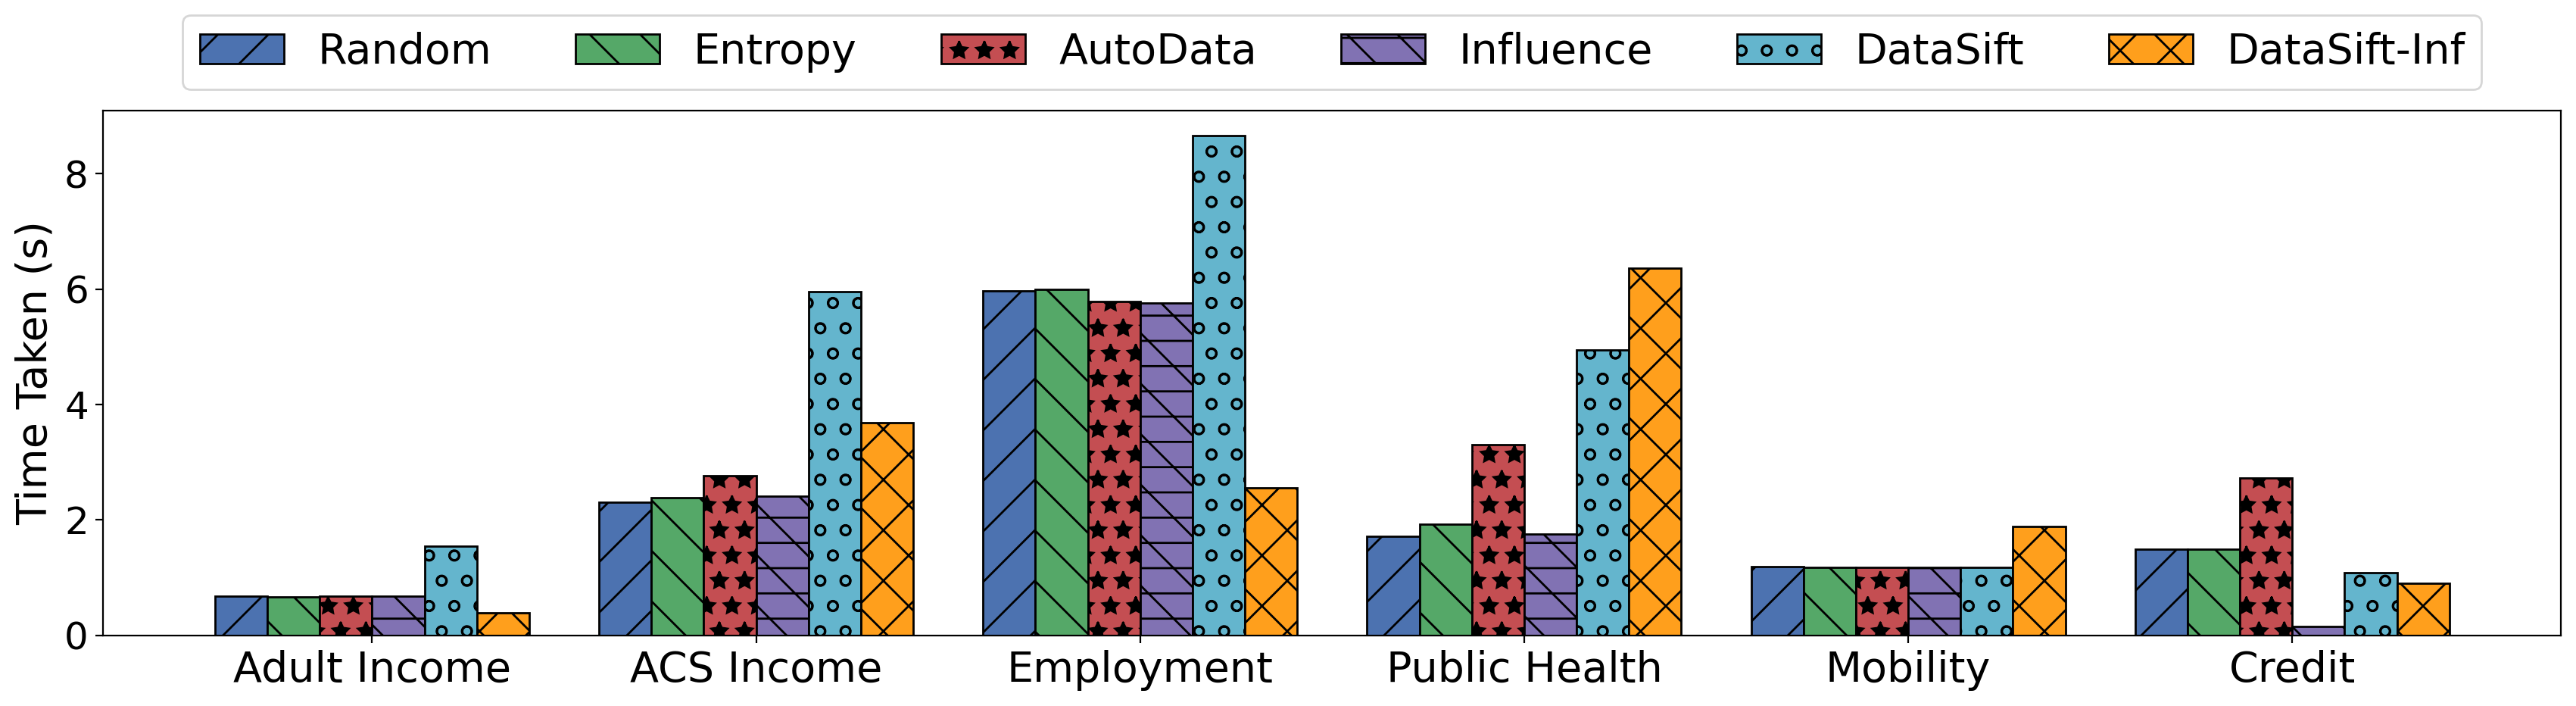

In [229]:
datasets = ['Adult Income', 'ACS Income', 'Employment', 'Public Health', 'Mobility', 'Credit']

methods = ['Random', 'Entropy', 'AutoData', 'Influence', 'DataSift', 'DataSift-Inf']
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#64B5CD', '#FF9F1C']


required_time_dataset_1 = [0.677, 0.661, 0.672, 0.68, 1.55,0.39]
required_time_dataset_2 = [2.30, 2.38, 2.76, 2.41, 5.96, 3.69]
required_time_dataset_3 = [5.97, 6.00, 5.79, 5.76, 8.66, 2.55]
required_time_dataset_4 = [1.718, 1.93, 3.30, 1.75, 4.94, 6.36]
required_time_dataset_5 = [1.187, 1.181, 1.17, 1.173, 1.176, 1.89]
required_time_dataset_6 = [1.49, 1.49, 2.73, 0.15, 1.09, 0.90]


required_times = [required_time_dataset_1, required_time_dataset_2, required_time_dataset_3, 
                  required_time_dataset_4, required_time_dataset_5, required_time_dataset_6]


hatch_patterns = ['/', '\\', '*', '\-', 'o', 'x']


n_datasets = len(datasets)
n_methods = len(methods)


bar_width = 0.15
gap = 0.2
index = np.arange(n_datasets) * (n_methods * bar_width + gap) 


plt.figure(figsize=(18, 5))


for i, (method, color, hatch) in enumerate(zip(methods, colors, hatch_patterns)):
    plt.bar(index + i * bar_width, [time[i] for time in required_times], 
            bar_width, label=method, color=color, edgecolor='black', hatch=hatch)




plt.ylabel('Time Taken (s)', fontsize=20)
plt.xticks(index + bar_width * (n_methods - 1) / 2, datasets, fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1), loc='lower center', ncol=n_methods)



plt.gca().set_facecolor('white')
plt.tight_layout()
plt.show()



## Sensitivity Analysis

## Clustering Method

In [230]:
'''plt.figure(figsize=(10,8))

plt.plot(
    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], 
    color='m', marker='s', linestyle='-', label='DataSift-Inf, CLusters'
)
plt.plot(
    [i for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], 
    [MAB_inf_parity_ex_pa[MAB_inf_iteration_count_ex_pa.index(i)] for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], 
    color='m', marker='s', linestyle='--', label='DataSift-Inf, States'
)

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='o', linestyle='-', label='DataSift, Clusters'
)

plt.plot(
    [i for i in i_values_ex_stat_pa if i % 1 == 0], 
    [stat_ex_pa[i_values_ex_stat_pa.index(i)] for i in i_values_ex_stat_pa if i % 1 == 0], 
    color='orange', marker='o', linestyle='--', label='DataSift, States'
)



plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')


plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)


plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=20, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()'''

"plt.figure(figsize=(10,8))\n\nplt.plot(\n    [i for i in MAB_inf_iteration_count_ex if i % 1 == 0], \n    [MAB_inf_parity_ex[MAB_inf_iteration_count_ex.index(i)] for i in MAB_inf_iteration_count_ex if i % 1 == 0], \n    color='m', marker='s', linestyle='-', label='DataSift-Inf, CLusters'\n)\nplt.plot(\n    [i for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], \n    [MAB_inf_parity_ex_pa[MAB_inf_iteration_count_ex_pa.index(i)] for i in MAB_inf_iteration_count_ex_pa if i % 1 == 0], \n    color='m', marker='s', linestyle='--', label='DataSift-Inf, States'\n)\n\nplt.plot(\n    [i for i in i_values_ex_stat if i % 1 == 0], \n    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], \n    color='orange', marker='o', linestyle='-', label='DataSift, Clusters'\n)\n\nplt.plot(\n    [i for i in i_values_ex_stat_pa if i % 1 == 0], \n    [stat_ex_pa[i_values_ex_stat_pa.index(i)] for i in i_values_ex_stat_pa if i % 1 == 0], \n    color='orange', marker='o', linestyle='--'

In [231]:
Stat_update_data_base, i_values_stat_base, i_values_ex_stat_base, stat_ex_base, stat_base, acc_stat_base, time_per_iteration_stat_base, cluster_count_base, iteration_time1_baseemployemempl = mab_algorithm_base(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=20, tau=0.025, budget=data_acq_size, alpha=0.1)

## Reward Score Selection

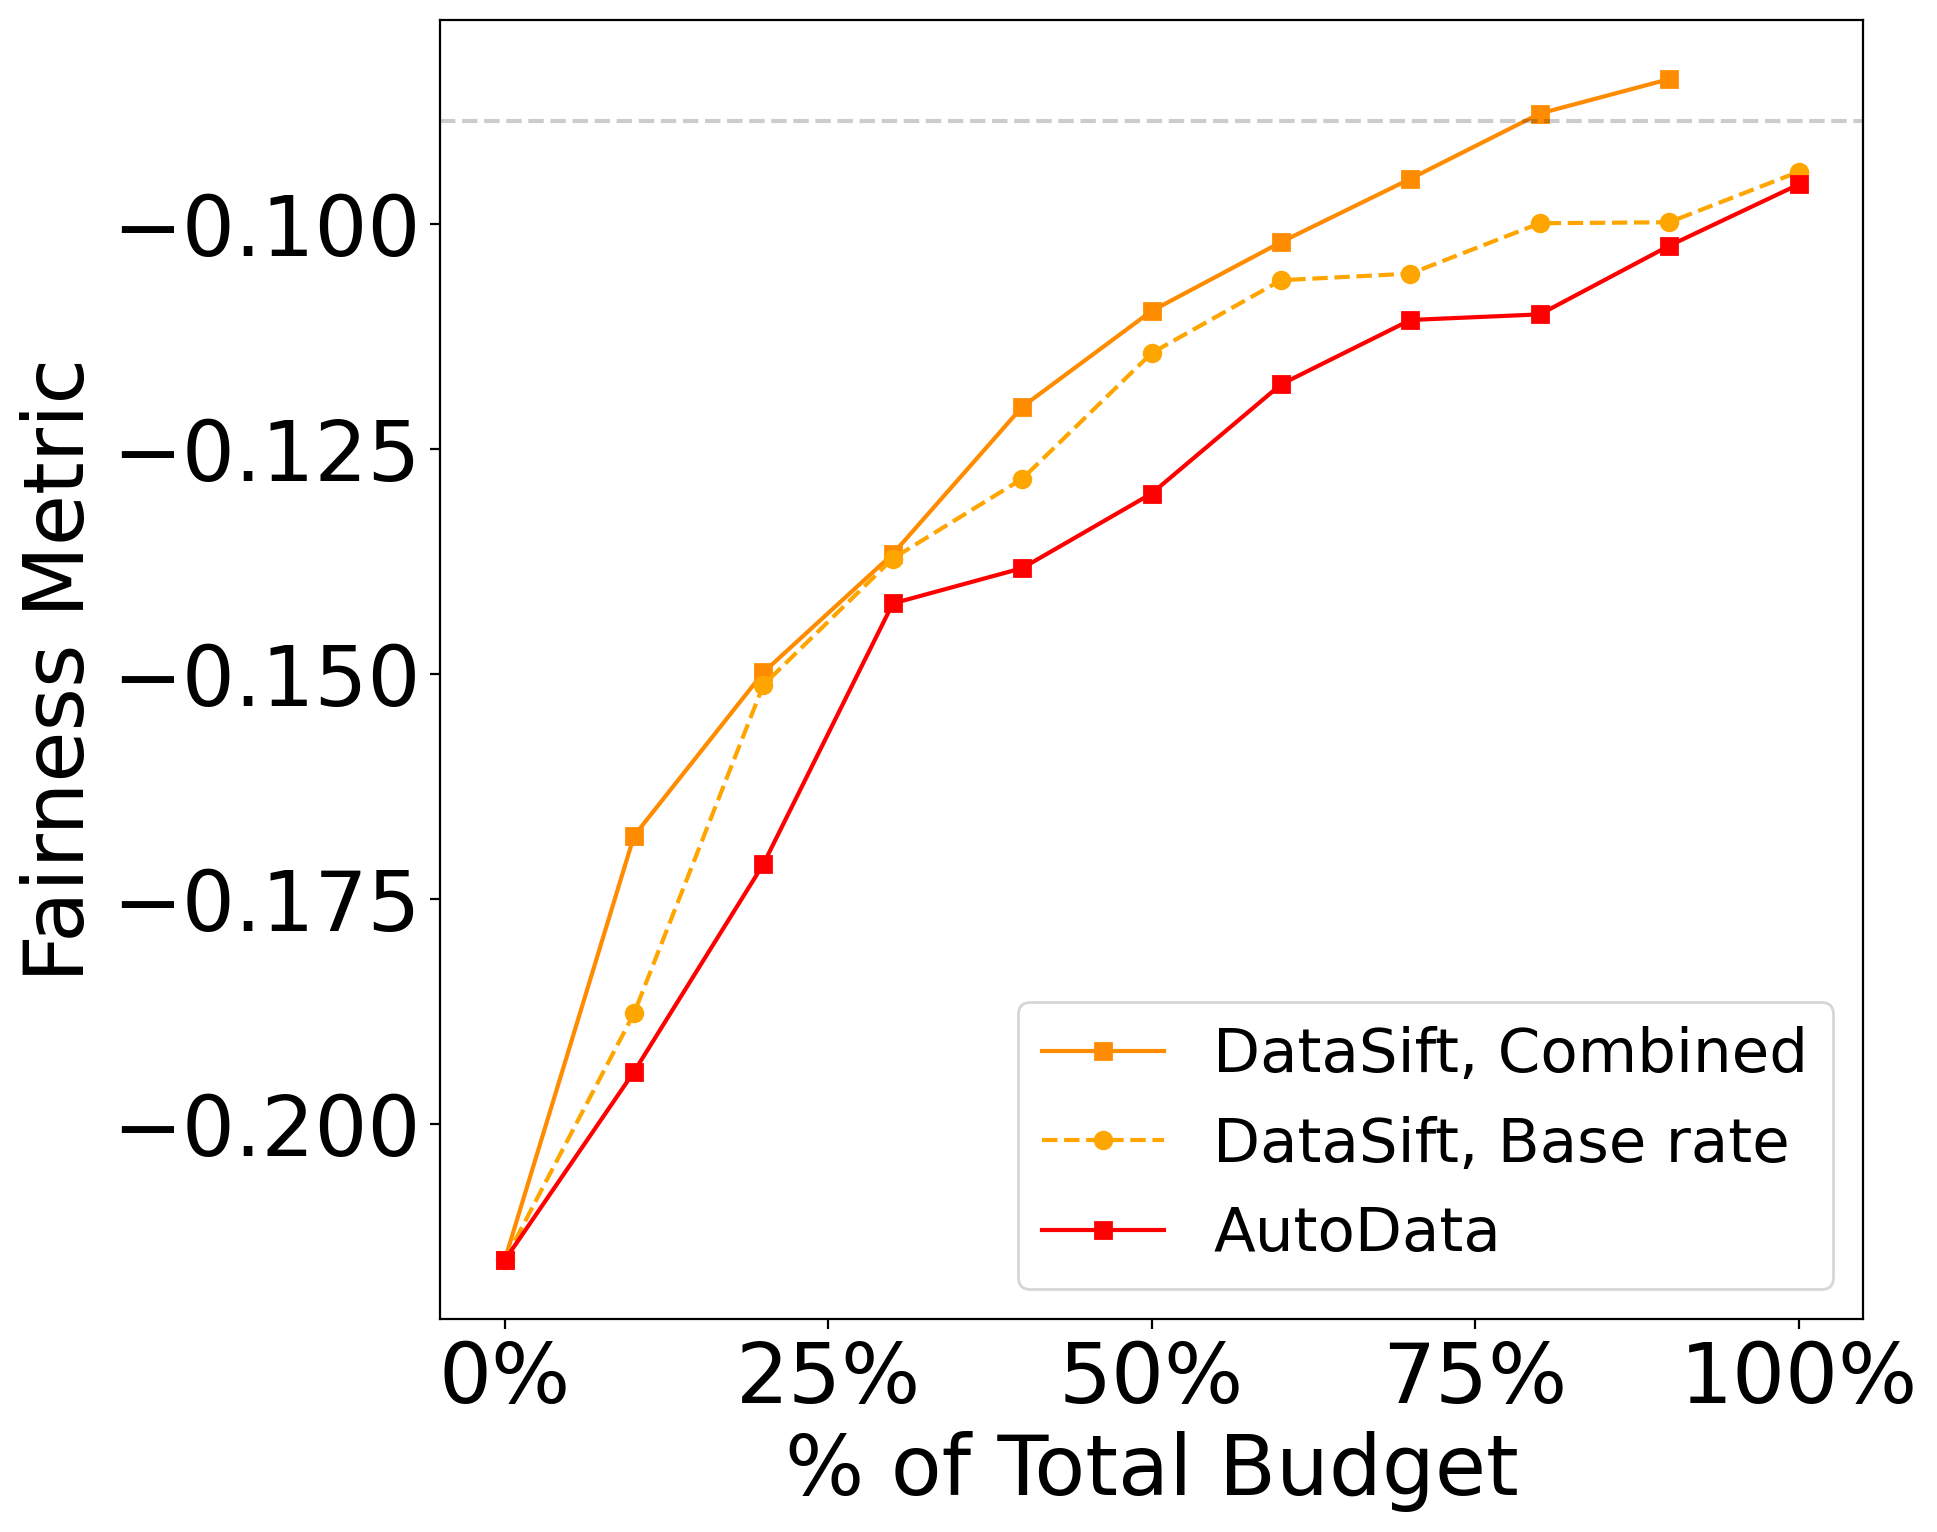

In [232]:
plt.figure(figsize=(10,8))

plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='#FF8C00', marker='s', linestyle='-', label='DataSift, Combined'
)
plt.plot(
    [i for i in i_values_ex_stat_base if i % 1 == 0], 
    [stat_ex_base[i_values_ex_stat_base.index(i)] for i in i_values_ex_stat_base if i % 1 == 0], 
    color='orange', marker='o', linestyle='--', label='DataSift, Base rate'
)
plt.plot(
    [i for i in i_values_ex_stat_dist if i % 1 == 0], 
    [stat_ex_dist[i_values_ex_stat_dist.index(i)] for i in i_values_ex_stat_dist if i % 1 == 0], 
    color='r', marker='s', linestyle='-', label='AutoData'
)

plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')


plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)


plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=22, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()

## ALpha

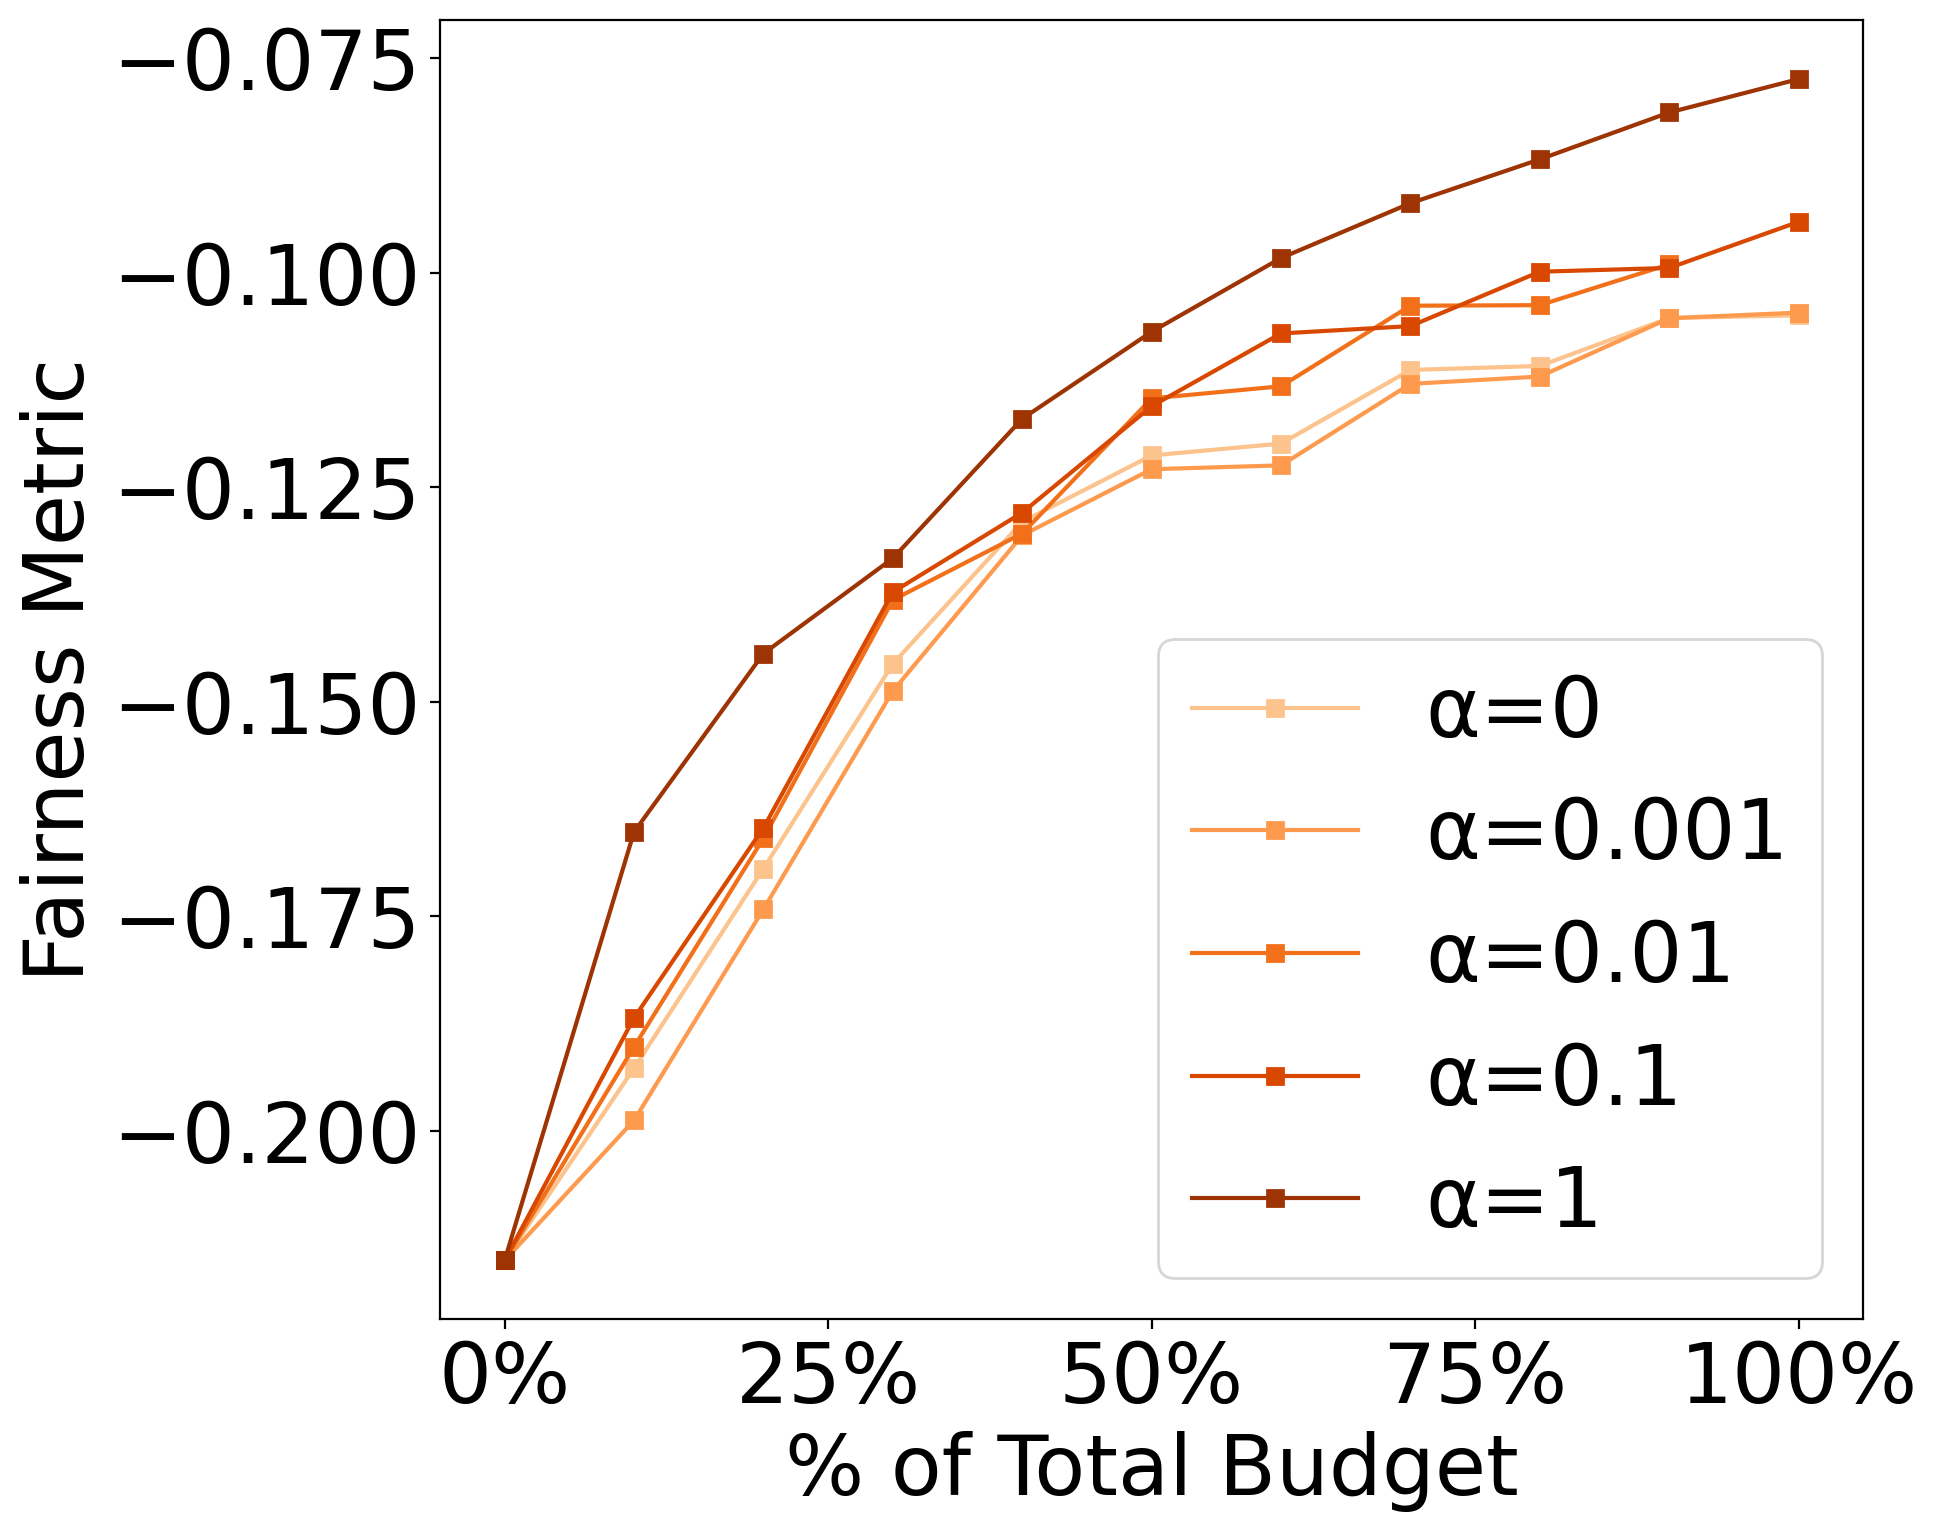

In [236]:
alpha = [0, 0.001, 0.01, 0.1, 1]
plt.figure(figsize=(10, 8))


cmap = plt.get_cmap('Oranges')
colors = cmap(np.linspace(0.3, 0.9, len(alpha)))


for idx, (i, color) in enumerate(zip(alpha, colors)):
    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(
        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute,
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=i)
    
    plt.plot(i_values_ex_stat, stat_ex, marker='s', linestyle='-', label=f'α={i}', color=color)


plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('% of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=30, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()

## Synthetic DataSet

In [237]:
print('DataSift', stat_ex[-1])
print('DataSift-Inf', MAB_inf_parity_ex[-1])
print('DataSift time', iteration_time1)
print('DataSift-Inf time', iteration_time_MAB_inf)

DataSift -0.07744906709902766
DataSift-Inf -0.0008310642452740158
DataSift time 3.7147183418273926
DataSift-Inf time 4.9699482917785645


In [238]:
Stat_update_data.shape

(39123, 11)

In [130]:
size = ['Original', 1e5, 2e5, 5e5, 1e6]
fairness_sys=[-0.08626, -0.0837, -0.11, -0.196, -0.138]
fairness_sys_inf=[-0.01561, 0.00731, -0.0066, -0.00166, 0.015]
time_sys=[1.45, 1.59, 1.735, 1.067, 1.718]
time_sys_inf=[0.38, 0.569, 0.71, 0.45, 1.017]

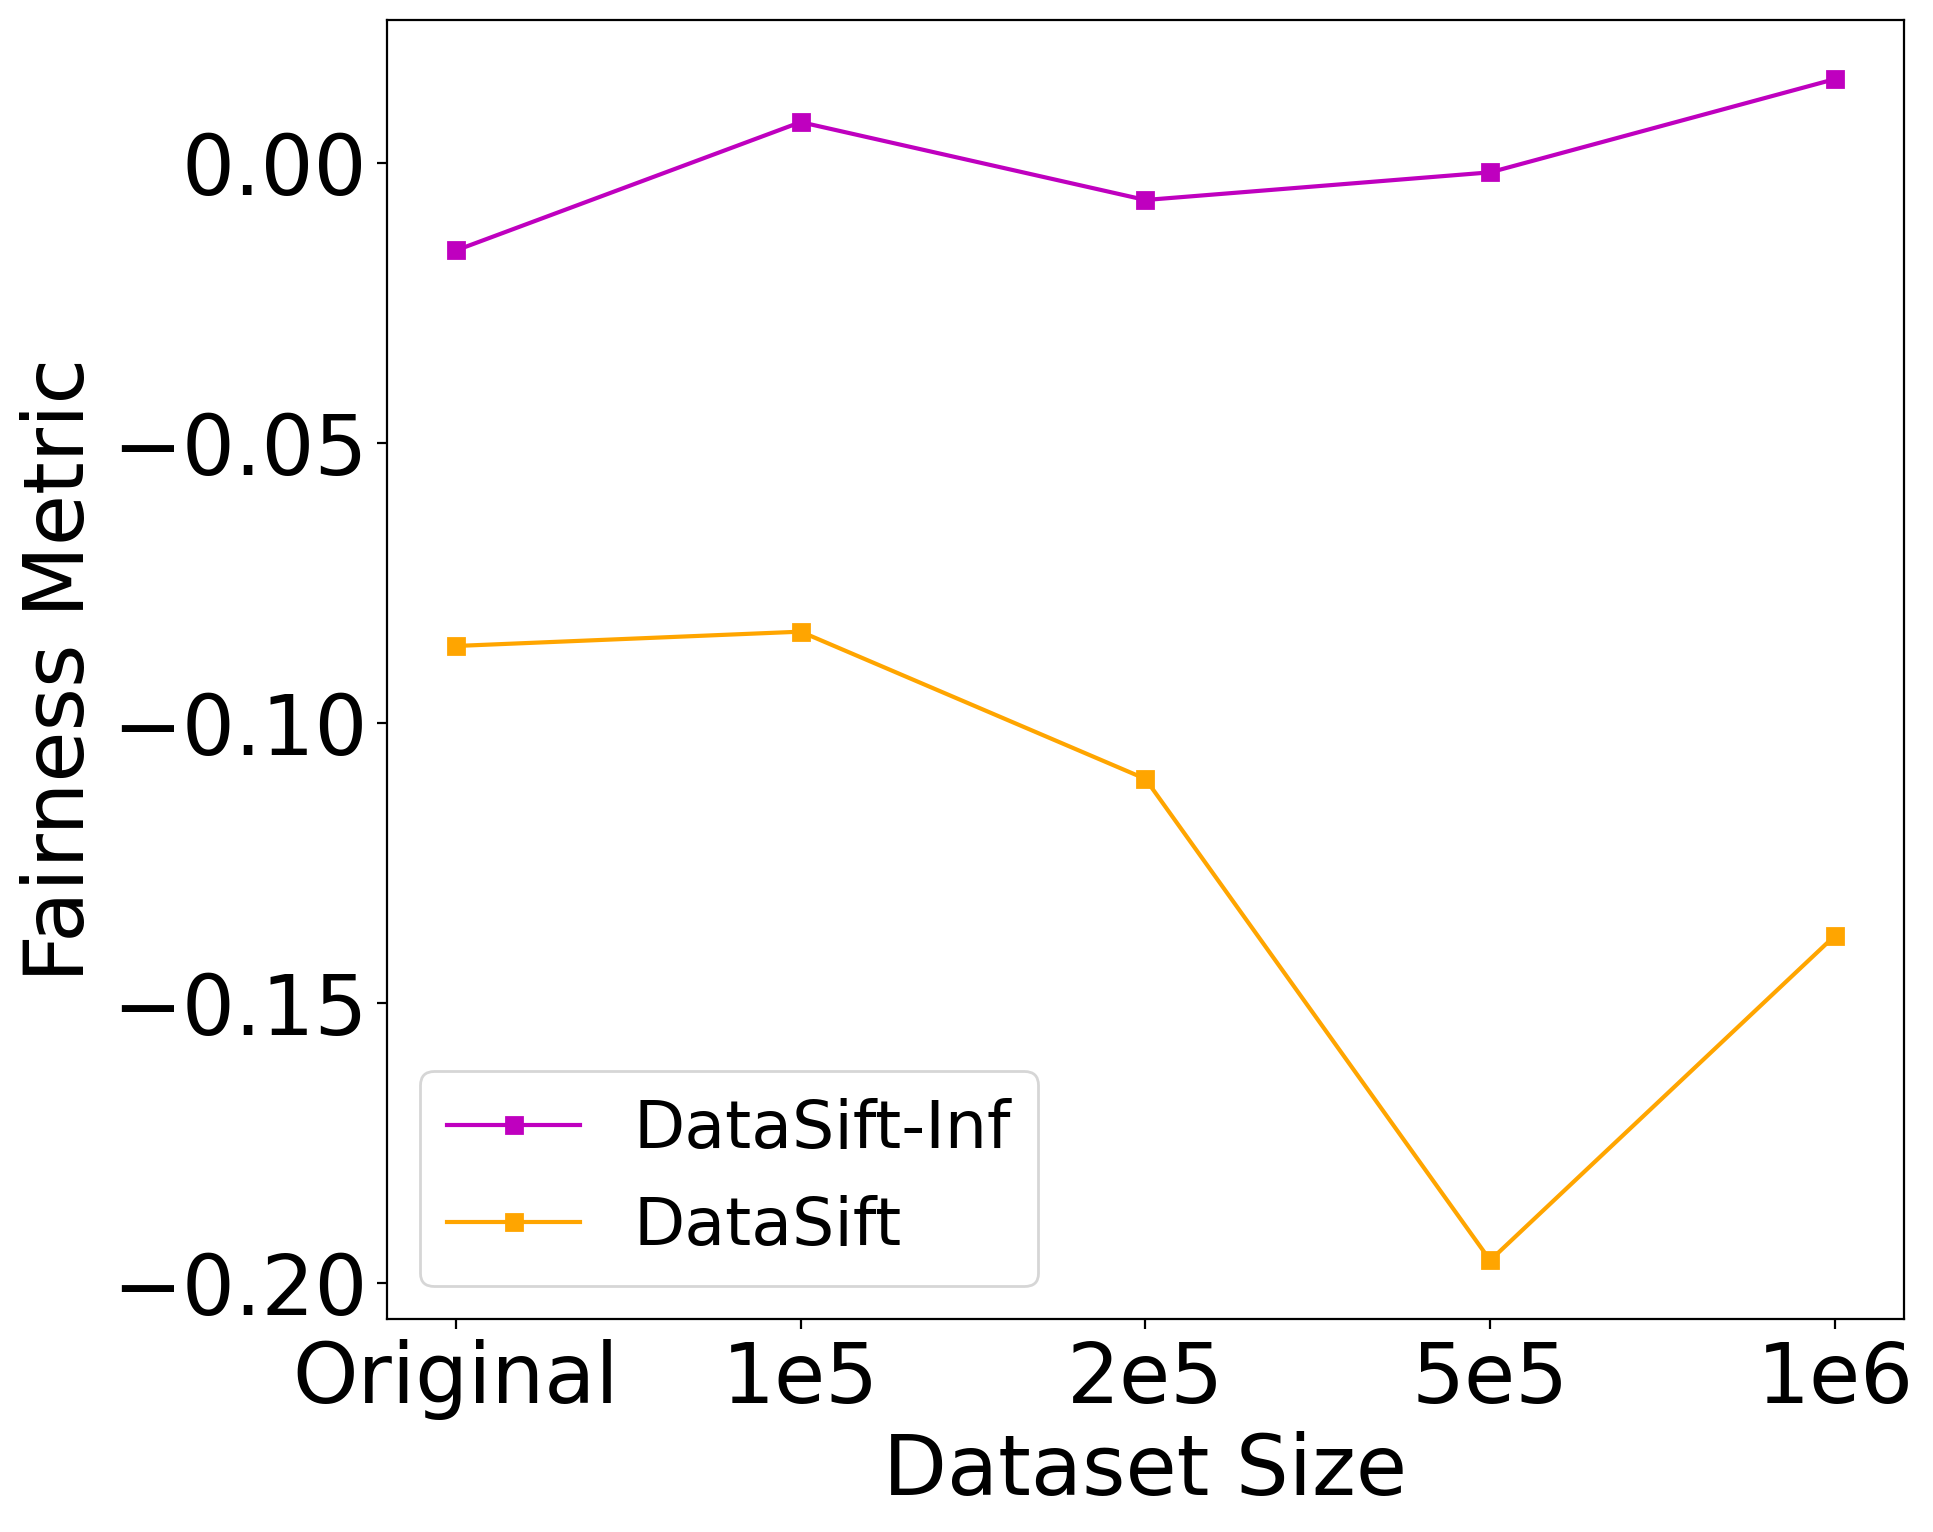

In [239]:


plt.figure(figsize=(10,8))
size = ['Original', '1e5', '2e5', '5e5', '1e6']
plt.plot(size, fairness_sys_inf, color='m', marker='s', linestyle='-', label='DataSift-Inf')
plt.plot(size, fairness_sys, color='orange', marker='s', linestyle='-', label='DataSift')

plt.xticks(range(len(size)), size)


plt.xlabel('Dataset Size', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.show()

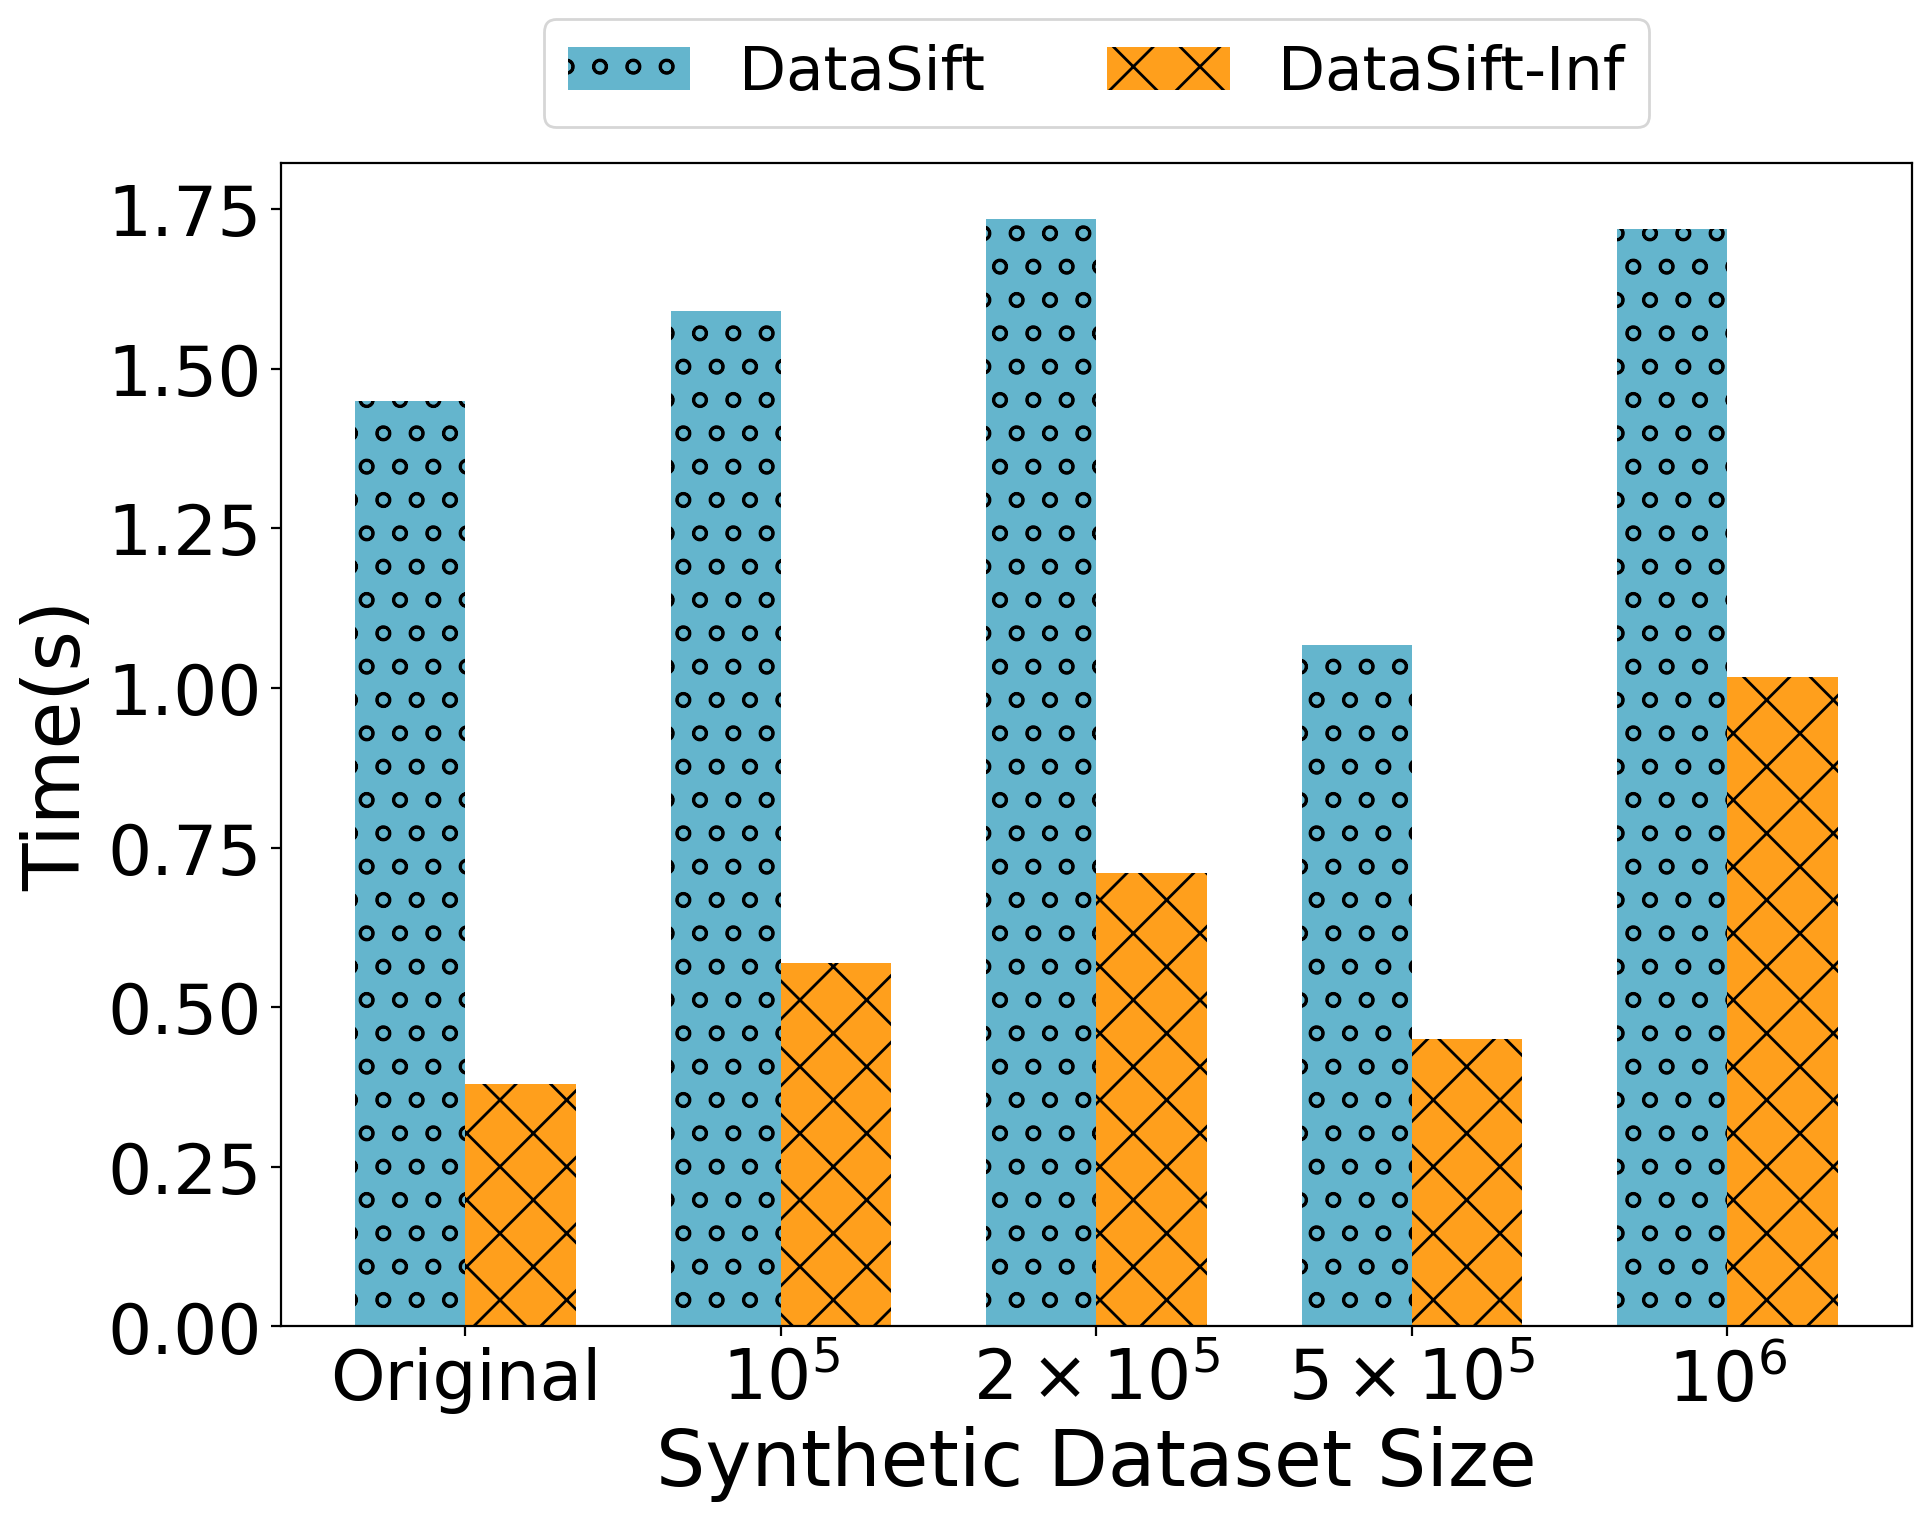

In [240]:
plt.figure(figsize=(10, 8))
bar_width = 0.35
index = range(len(size))


plt.bar(index, time_sys, width=bar_width, color='#64B5CD', label='DataSift', hatch='o')
plt.bar([i + bar_width for i in index], time_sys_inf, width=bar_width, color='#FF9F1C', label='DataSift-Inf', hatch='x')

log_ticks = [1, 1e5, 2e5, 5e5, 1e6]
log_labels = ['Original', '$10^5$', '$2\\times 10^5$', '$5\\times 10^5$', '$10^6$']

plt.xticks([i + bar_width/2 for i in index], log_labels)
plt.xlabel('Synthetic Dataset Size', fontsize=28)
plt.ylabel('Time(s)', fontsize=28)
plt.legend(fontsize=22, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.tick_params(axis='both', which='major', labelsize=25)


plt.tight_layout()
plt.show()

## Mini-Batch Size

In [241]:
mini_batch_pct = [2, 4, 6, 8, 10, 12, 15]
budget_pct = 20
data_acq_size = int(datapool.shape[0] * budget_pct // 100)

x_values = mini_batch_pct

mab_values = []
mab_inf_values = []
inf_values = []
random_values = []
entropy_values = []

for i in mini_batch_pct:
    mini_batch_size = int(data_acq_size * (i / 100))

    Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(
        clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, 
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=0.1)
    mab_values.append(stat_ex[-1])

    MAB_inf_update_data, MAB_inf_iteration_count, MAB_inf_iteration_count_ex, MAB_inf_parity_ex, stat_MAB_inf, MAB_inf_accuracy_ex, MAB_inf_time_per_iteration, MAB_inf_cluster_count, iteration_time_MAB_inf = mab_inf_algorithm(
        sort_by_inf_partition, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, 
        mini_batch_size=mini_batch_size, max_iteration=20, tau=0.01, budget=data_acq_size, alpha=0.1)
    mab_inf_values.append(MAB_inf_parity_ex[-1])


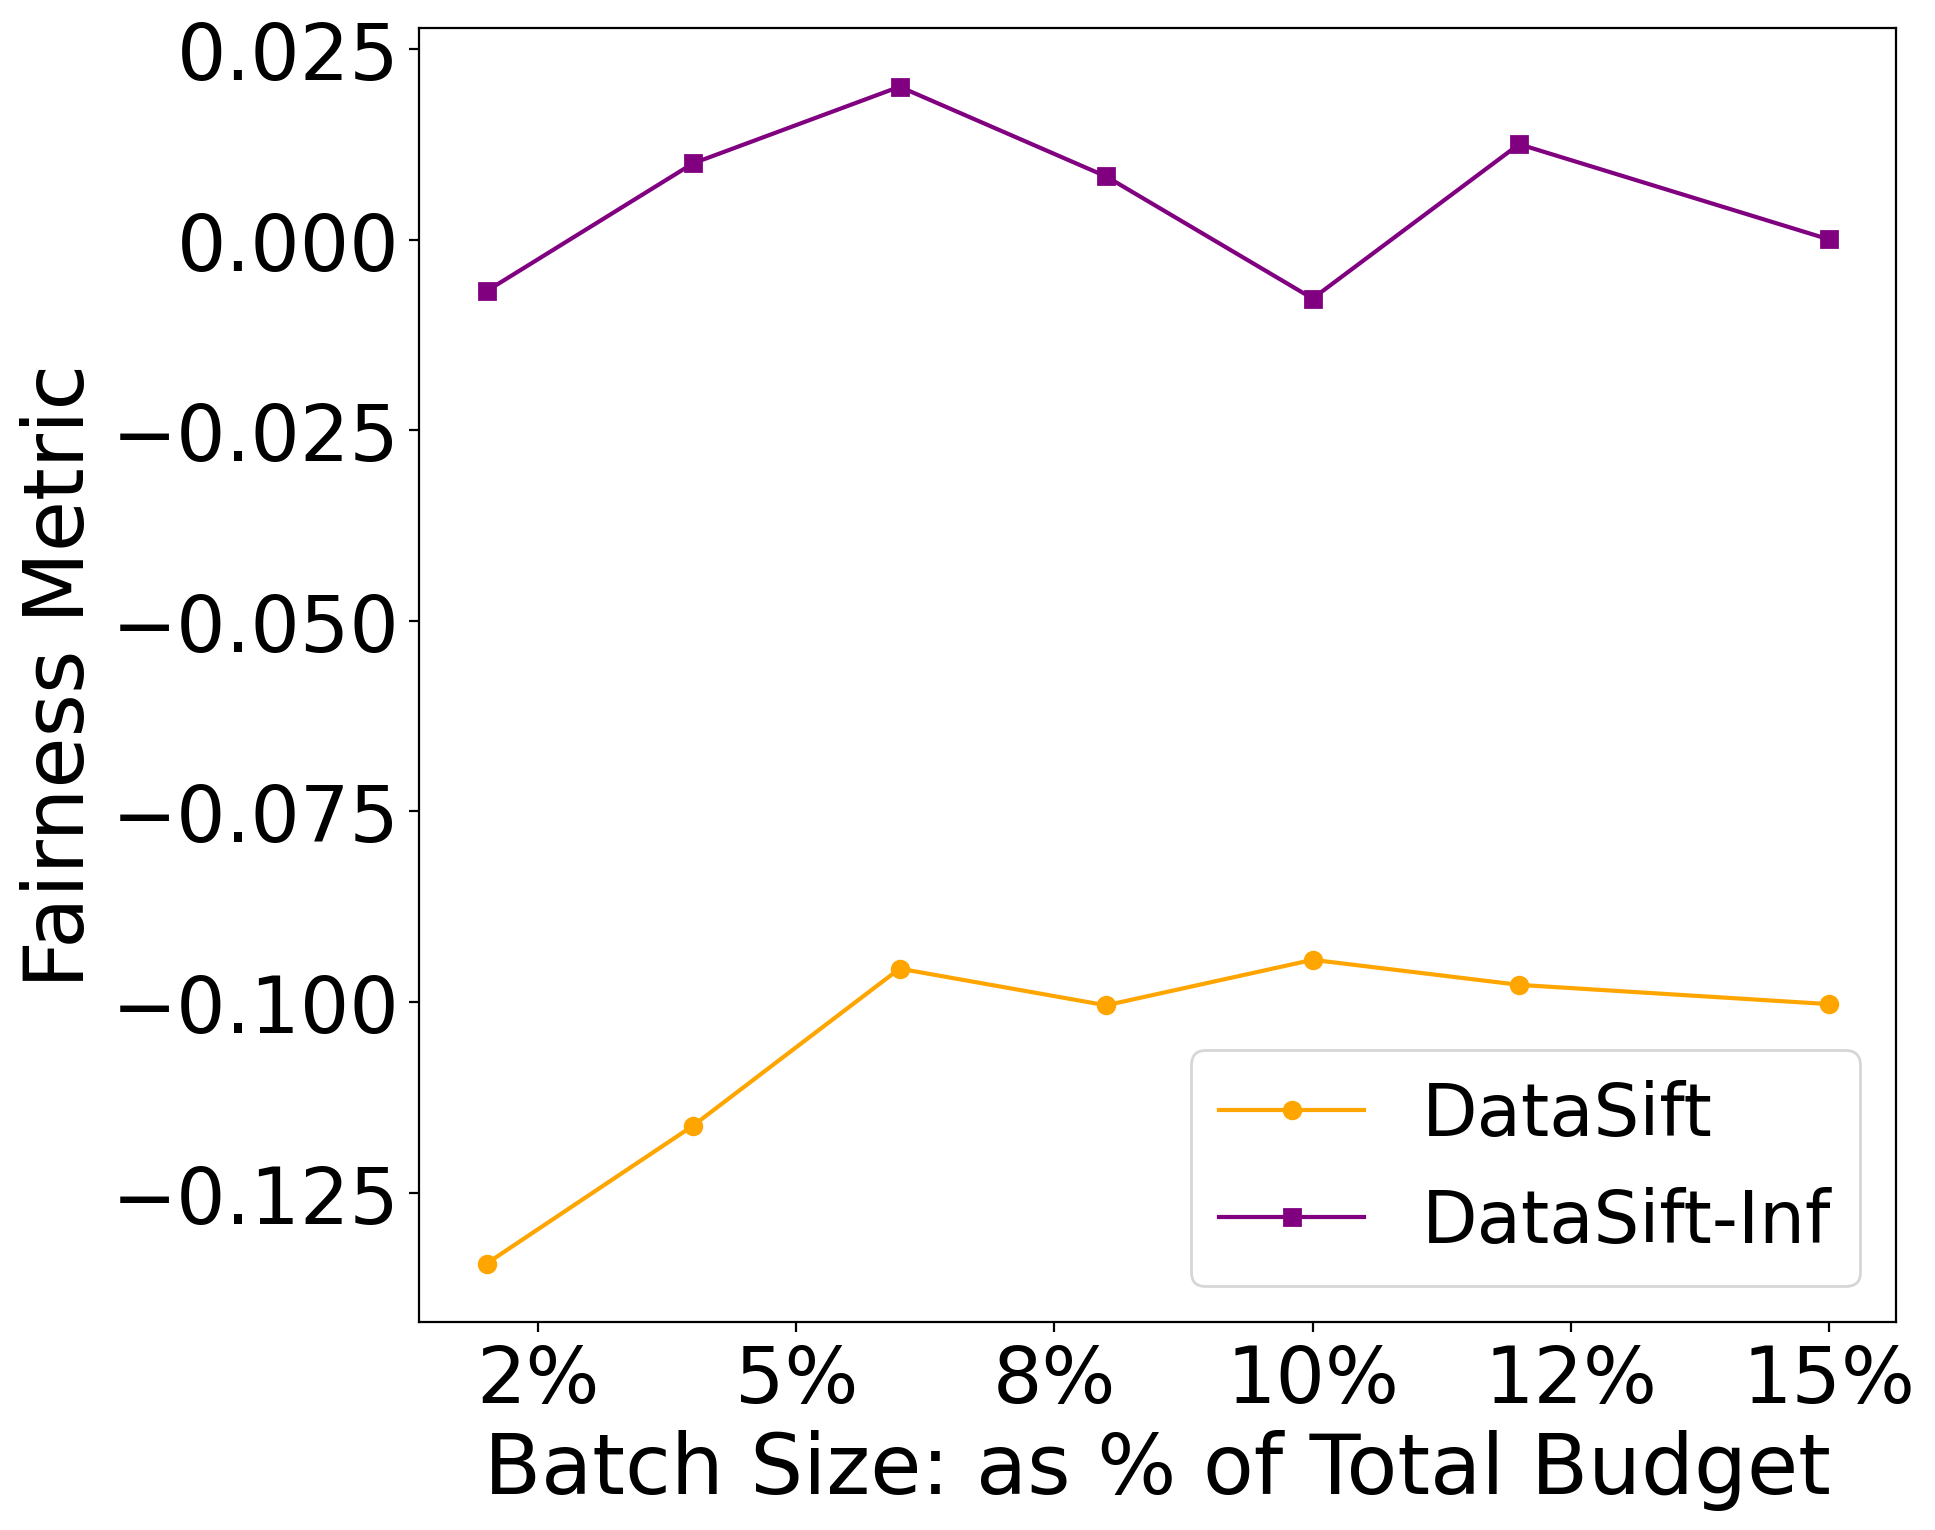

In [242]:
plt.figure(figsize=(10, 8))

plt.plot(x_values, mab_values, marker='o', linestyle='-', color='orange', label='DataSift')
plt.plot(x_values, mab_inf_values, marker='s', linestyle='-', color='purple', label='DataSift-Inf')

plt.xlabel('Batch Size (%)', fontsize=20)
plt.ylabel('Fairness Metric', fontsize=20)

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'{x:.0f}%')
)

plt.xlabel('Batch Size: as % of Total Budget', fontsize=30)
plt.ylabel('Fairness Metric', fontsize=30)
plt.legend(fontsize=26, ncol=1)


plt.tick_params(axis='both', which='major', labelsize=28)
plt.tight_layout()
plt.show()